# 0. Marking.

***IMPORTANT***: Save a copy of this notebook into your Drive before you start.
- Please attempt all the questions marked for your group (Part II ✅ | Part III/MPhil ✅).
- **We assume you will use the provided seeds. If you do not, please save all seeds that you use in the provided enum.**

Please submit a zip file containing (a) a text file with a publicly visible link to your notebook in Google Colab; (b) a downloaded copy (ipynb) of your notebook. You may treat this as a report: we will not be re-executing the code you used to produce the answers unless required.

If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.

## Imports

In [ ]:
# The simulation component of flower uses RAY under the hood.
# `pip` could produce some errors. Nothing to worry about.
# The execution has been verified; it is working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet 'flwr[simulation]' torch torchvision  gdown tqdm seaborn torchsummary pycrypto pycryptodome cryptography tensorflow-privacy matplotlib
# The following is just needed to show the folder tree
! apt-get install -qq tree


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 31.4 MB/s eta 0:00:00


In [ ]:
## Imports
import csv
import numbers
import os
import random
import pickle
from collections import OrderedDict, defaultdict
from copy import deepcopy
from pathlib import Path
from typing import *


import flwr as fl
import ray
import gdown
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.common import Metrics, Config, GetPropertiesIns, GetPropertiesRes, MetricsAggregationFn
from flwr.common.parameter import ndarrays_to_parameters,parameters_to_ndarrays
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig
from flwr.server.client_manager import SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum
from datetime import datetime,timezone
import json

# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337

np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False # type: ignore
torch.backends.cudnn.deterministic = True # type: ignore

def convert(o):
    if isinstance(o, np.int64) or isinstance(o, np.int32): return int(o)  
    if isinstance(o, np.float32) or isinstance(o, np.float64): return float(o)  
    raise TypeError

def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT, **kwargs):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)

PathType = Optional[Union[Path, str]]

def get_device() -> str:
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

### Dataset

In [ ]:
home_dir = Path("/content")
# home_dir = Path("/Users/lorenzosani/My drive (aai30@cam.ac.uk)/Teaching/FL_2022-2023/")
# home_dir = Path("/Users/iacobalexandru/projects/FL_LABS_2023/")
devices_info_dir: Path = home_dir / "device_info"
statistical_utility: Path = home_dir / "statistical_utility.csv"
dataset_dir: Path = home_dir / "femnist"
# dataset_dir = Path("/Users/lorenzosani/tmp/femnist/femnist")
# dataset_dir = Path("/Users/iacobalexandru/projects/FL_LABS_2023/femnist")
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"
(home_dir / "histories").mkdir(exist_ok=True,parents=True)


In [ ]:
def save_history(hist, name):
  time = int(datetime.now(timezone.utc).timestamp())
  with open(home_dir / "histories" / f"hist_{time}_{name}.json", "w", encoding="utf-8") as f:
            json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)

def start_seeded_simulation(
    client_fn,
    num_clients,
    client_resources,
    server,
    config,
    strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
):
    """Wrapper to always seed client selection."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    hist =  fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources=client_resources,
        server=server,
        config=config,
        strategy=strategy,
    )
    save_history(hist, name)
    ray.shutdown()
    return hist

In [ ]:
# Download the compressed dataset
if not (home_dir / "femnist.tar.gz").exists():
    id = "1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist.tar.gz"),
    )
    
# Decompress dataset 
if not dataset_dir.exists():
  !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
  print(f"Dataset extracted in {dataset_dir}")

### Python files

In [ ]:
if not (home_dir / "femnist_dataset.py").exists():
    id = "11xG4oIhdbVcDtXxbS2ZosDSJYAC0iL7q"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist_dataset.py"),
    )
if not (home_dir / "client.py").exists():
    id = "1lvEAVxgsc8T4_cJuqymJLyHO5cxS5KCD"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "client.py"),
    )
if not (home_dir / "client_utils.py").exists():
    # id = "1eIhCgEKh4zCX-63Ax35kCSV4UNo9Cqzt" # w/ tqdm
    id = "1-gz-wZhadx51wOHqmkrxihDaWPh4MlmE"  # w/o tqdm
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "client_utils.py"),
    )
if not (home_dir / "client_manager.py").exists():
    id = "1-XZKJ2FPwHZoMA0Dr4bZ4YC4bM_qfD2r"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "client_manager.py"),
    )
if not (home_dir / "strategy.py").exists():
    id = "1-WTr8NxLcNOXouUxM8ckg8cG9n5G8v8f"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "strategy.py"),
    )
if not (home_dir / "server.py").exists():
    id = "10GDKir44WLfs8ZH0EGYexUxKgEIdO5xQ"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "server.py"),
    )


In [ ]:
from client import FlowerRayClient, get_flower_client_generator
import server
from server import Server, NewHistory as History
import client_manager
from client_manager import CustomClientManager
from strategy import DeterministicSampleFedAvg as FedAvgM
from client_utils import (
    get_network_generator_cnn,
    get_model_parameters,
    aggregate_weighted_average,
    get_federated_evaluation_function,
    get_default_test_config,
    get_default_train_config,
)


# 1. Introduction.


Welcome to the fourth lab session in our FL course. Having explored standard FL, data heterogeneity and device heterogeneity, we now focus on one of FL's main selling points: privacy. 

The two methods for achieving privacy we will explore are client-level [Differential Privacy](https://ieeexplore.ieee.org/abstract/document/9069945) and [Secure Aggregation](https://research.google/pubs/pub45808/). Intuitively, the first provides a probabilistic bound on how distinct the final model trained using the data of a given client would be from the same model trained without data from that client (thus if a client contains all samples from a given class, it should be difficult for the model to predict that class as it would have to violate DP). In an ideal privacy scenario, we would prefer it if two models trained with or without the data of a given client were indistinguishable. The second is a cryptographic solution that effectively erases the ability to identify a client during aggregation by encrypting all client model updates to produce the correct aggregate when summed. 

As these topics are pretty in-depth, we will not cover them to the same level of detail as previous labs concerning theoretical subjects (such as data heterogeneity in lab 2). This lab will be primarily experimental to test the algorithms put into practice. We will, however, begin with a light introduction. Suppose you are interested in learning more about the subject. In that case, we may recommend the following papers [Deep Learning with Differential Privacy](https://arxiv.org/pdf/1607.00133.pdf) \[1], [Learning Differentially Private Recurrent Language Models](https://arxiv.org/pdf/1710.06963.pdf) \[2] and [Differentially private learning with adaptive clipping](https://arxiv.org/abs/1905.03871) \[3] on the DP front. For secure aggregation consider the original paper [Practical Secure Aggregation for Federated Learning on User-Held Data](https://arxiv.org/pdf/1611.04482.pdf) \[4] and the improved [LightSecAgg](https://arxiv.org/abs/2109.14236) \[5].

Secure aggregation does not harm the model's accuracy and demands only increased communication. Any samples involved in training may still be reconstructed in an attack; however, knowing who contributed the samples will not be possible. Thus, while the implementation is complex, its behaviour is predictable and shall be reserved for the end of the notebook as we are only concerned with measuring communication costs and answering conceptual questions. As such, let us dive into Differential Privacy after the following well-known imports.

>**Important** the entire notebook has been tested in a GPU-enabled collab environment which runs at around 6 minutes per FL experiment. All experiments require you to vary at most one parameter at a time, so please use a for loop to generate a list of histories rather than trying to manage multiple cells---most experiments rely on one run we create for demonstration purposes to cover one of the desire parameter values. We have purposefully reduced the size of the federated test set significantly and have also reduced the overall number of clients used during FL experimentation. If you are more constrained in your resources (e.g., you have run out of google accounts which can get a GPU or you get an error peculiar to your exact colab machine), let us know either on slack or in your submission, and we will either help you set up the code locally, potentially provide you with history objects, or offer take this into account during marking.


Citations:


1.   Abadi, Martin, et al. "Deep learning with differential privacy." Proceedings of the 2016 ACM SIGSAC conference on computer and communications security. 2016.
2.   McMahan, H. Brendan, et al. "Learning differentially private recurrent language models." arXiv preprint arXiv:1710.06963 (2017).
3. Thakkar, Om, Galen Andrew, and H. Brendan McMahan. "Differentially private learning with adaptive clipping." arXiv e-prints (2019): arXiv-1905.
4. Bonawitz, Keith, et al. "Practical secure aggregation for federated learning on user-held data." arXiv preprint arXiv:1611.04482 (2016).
5. So, Jinhyun, et al. "Lightsecagg: a lightweight and versatile design for secure aggregation in federated learning." Proceedings of Machine Learning and Systems 4 (2022): 694-720.



# 2.Deep Learning With Differential Privacy

Before diving into a definition of Differential Privacy adapted to an FL context, we shall begin with the first version of DP applied to Deep Learning based on the aforementioned paper.

The authors of the original extension of DP to Deep Learning justify the need for such a privacy mechanism based on the possibility that an attacker may reconstruct specific samples from the data perfectly in a sensitive context, such as facial recognition, while only having **black-box** access to the trained model. However, their algorithm for DP protects against even adversaries with full knowledge of the training procedure, access to the parameters and potential control over parts of the dataset. 

Their definition of DP is as follows: $Pr[M(d) \in S] \leq e^{\epsilon} Pr[M(d') \in S] + \delta$ , where d and d' are considered adjacent if they differ by one record (training sample in our case) only. We can interpret this as stating that the probability of getting a particular output from our model when not including a specific sample should be close to the probability of getting the same output had we not included the sample. Specifically, when $\epsilon=0$, the two probabilities are equal, and it is impossible to find out if that sample was included in the training set. Values of $\epsilon>0$ provide less protection with the probability that the model produces different outputs when trained on adjacent datasets increasing exponentially with $\epsilon$.

>Importantly, the original definition of DP and the one you may have encountered before only contained the exponential term without the $\delta$; however, this resulted in very strong requirements for not breaking privacy. This new form, $(\epsilon, \delta)$ privacy relaxed the requirement. Informally, it can be interpreted as allowing privacy at a given $\epsilon$ level to be broken with probability $1-\delta$. We do not have the scale of experimentation necessary to consider both in this lab, as such we will focus on $\epsilon$ values at the detriment of analysing changes in $\delta$. For the experiments in this lab, you can consider DP to be defined entirely in terms of ϵ. Formally, the transition to $(\epsilon, \delta)$ delta was necessary to move from an inefficient noise generation mechanism to Gaussian noise as ML models are much more complex than typical vector-valued functions. 

Differentially private approximations of functions are usually constructed by the addition of noise proportional to the sensitivity of the function---think of it as the maximal impact that the addition or removal of a data point can have upon the output of the function. From now on, we shall refer to this noise level as the `noise_multiplier` as it scales the noise multiplicatively based on the sensitivity. When DP was extended to a DL context, making the system differentially private by intervening upon the gradients used during training rather than the final model was significantly more straightforward than operating on the model as a function after training. In the context of ML model updates (gradient descent steps or pseudo-gradients in FL), their sensitivity is generally defined in terms of the l2 norm (when noise is Gaussian) of the update, and the noise is thus scaled based on this norm.

As such, the original DP-SGD operates as follows:

1.   Compute the derivative concerning each sample (not minibatch)
2.   Clip the l2 norm of the derivative so it falls below a given bound.
3.   Aggregate these clipped derivatives and add Gaussian noise to obfuscate the impact of specific samples used to compute the gradients. Make the noise proportional to the l2 bound. 

Suppose we reframe DP to the original context of databases and records. In that case, the larger the number of noisy answers the database offers, the more an attacker can eliminate the noise by looking at the entire distribution of answers. Similarly, the more samples out of the total an ML model sees (or the more times it sees the same sample), the more the noise of the sample gradients average out. For a model to be trained for an extended period, it is thus necessary to use a higher `noise_multiplier`. We shall soon extend this trade-off to clients within an FL context. 

While this process operates reasonably in the context of centralised, applying DP-SgD on every client in FL is problematic, given the reduced efficiency of the training method. As a result of this inefficiency, the federated model will likely incur significant drops in its already low performance. Furthermore, multiplel studies have confirmed that applying DP locally has disastrous effects on the accuracy of the final federated model. 

# 3.User-level Differential Privacy

Differential privacy at a client/user level in FL follows the same definition, except adjacent datasets are constructed by adding or removing all samples from a given client. Thus, under maximum privacy scenarios with $\epsilon=0$ and $\delta=0$ two models should behave identically regardless of the presence of a specific user in the federation. For user-level DP, training with more users (rather than samples) results in the degradation of privacy. Thus, the `noise_multiplier` necessary to make an Fl system differentially private with respect to an l2 norm bound depends on the total number of users, the number of users sampled every round and the number of rounds.

DP-FedAvg represents a reasonably direct analogue to DP-SgD as it applies the same process to FL pseudo-gradients that DP-SgD applies to gradients generated by one sample. Namely, it clips the gradients based on the L2 norm on the local client after training. The server then adds Gaussian noise related to the l2 norm bound via the `noise_multiplier` when it receives the gradients. 

However, this extension is hampered by the fact that DP-SgD assumes an IID distribution of samples. As we, clients in FL contain non-IID data and have skewed numbers of samples. As such, for the theoretical privacy guarantee to hold DP-FedAvg must assume that clients will not drop out and that the overall set of available clients in the population is static---both being significant limitations. Furthermore, unweighted aggregation is usually enforced since weighted aggregation is more likely to leak data from a specific user. An additional note worth making is that even when violating the theoretical assumptions of DP, applying noise and clipping gradients is still likely to make reconstructing data belonging to a specific client more difficult in practice. 

One final theoretical concern worth addressing prior to experimentation is the nature of the l2 norm clipping. Two specific questions arise in the early works discussing DP-FedAvg:
 
*   Should the clipping be done per layer or uniformly across the entire model? Consider scenarios where a single large layer encodes all the relevant information about a specific user and is not clipped because the overall l2 norm of the gradient is lower than a generic bound. 
*   How should a l2 bound be chosen and changed? If the model updates are too small, the model is less likely to learn. However, a more oversized bound implies more noise and thus leads to potential degradation yet again. 

These questions have been answered by follow-up work. On the first point, this stack overflow answer by one of the authors of paper \[3] above indicates that per-layer bounding leads to worse performance as it is harsher for little benefit. On the second point, methods for efficiently tracking a given quantile of the l2 distribution amongst client updates were proposed in \[3]. We will glance at this adaptive mechanism in today's lab but shall not examine it in detail.

**Question 1 (Part II ✅ | Part III/MPhil ✅):**


(This is a conceptual question. Please do not provide more than three sentences per sub-question.)


Consider two applications of FL, next-word prediction and image classification based on personal user data from smartphones. 

1. What kind of sensitive information could be extracted from models trained on these tasks? 
2. How would DP help preserve privacy for each task? 
3. Would sample-level or client-level DP be preferable for the more sensitive task?

**Question 1 Answer**

1.	For image classification based on personal user data from smartphones, images related to personal information may be recovered such as human faces, indoor room pictures, etc. For next-word prediction, users’ typing habits may be recovered, which can sometimes be dangerous as it may expose personal routines and sensitive information such as passwords and search queries [1]. It can be more dangerous if the user is a celebrity or an important person.

2.	Deep learning models induce privacy concerns as they sometimes can memorize the patterns of individual data points but do not generalize well to the whole data distribution [2]. In the non-federated setting, DP prevents the reconstruction of a single data point. In the federated setting, DP facilities both anonymization (i.e., which clients hold the data is unknown) and anti-reconstruction [3].

3.	Client-level DP extends on sample-level DP such that effects of the arbitrary substitution of many data samples or the entire client’s local dataset are minimized by clipping client’s trained models. Since client-level DP offers stronger privacy protection from this aspect, I think client-level DP is more preferable for more sensitive tasks because we want to protect all data from a device but not a single data sample. As an example, the sensitive photos in users’ smartphone consist of different distributions such as selfies taken at home and pictures of workspace, and we can imagine each distribution represents a client.

[1] https://arxiv.org/abs/1710.06963 \
[2] https://arxiv.org/abs/1611.03530 \
[3] https://ai.googleblog.com/2022/02/federated-learning-with-formal.html


**Question 2 (Part III/MPhil ✅):**

(This is a **short** conceptual question. Please do not provide more than four sentences as an answer.)

The DP-SgD algorithm could be applied entirely locally by a given client. This should serve to obfuscate each one of their samples at a very high accuracy cost. What additional assumptions does DP-FedAvg require for its improvements in efficiency? Consider the trust dynamics between the client and the server.


**Question 2 Answer**

First, device availability cannot be changed significantly [1]. Second, the server will not use information related to clients such as knowledge of the population size and model history in a malicious way [2]. Third, we assume all clients agree to participate in the training across rounds [2]. 

[1] https://arxiv.org/abs/2103.00039 \
[2] https://arxiv.org/abs/2007.06605


## 3.1 Fixed Norm Bound DP

We shall begin by implementing the `DPFedAvg` strategy based on the description above using a static bound on the l2 norm of clients. While we could near-effortlessly add client-level Differential Privacy by using wrappers provided by Flower, implementing its components should be straightforward and informative.

The first cell provides utilities for gradient clipping and noise injection. The clipping operates via simple multiplication.

In [ ]:
def compute_model_delta(trained_parameters: NDArrays, og_parameters: NDArrays):
    return [np.subtract(x, y) for (x, y) in zip(trained_parameters, og_parameters)]


def compute_norm(update: NDArrays) -> float:
    """Compute the l2 norm of a parameter update with mismatched np array shapes, to be used in clipping"""
    flat_update = update[0]
    for i in range(1, len(update)):
        flat_update = np.append(flat_update, update[i])  # type: ignore
    squared_update = np.square(flat_update)
    norm_sum = np.sum(squared_update)
    norm = np.sqrt(norm_sum)
    return norm


def clip_by_l2(update: NDArrays, threshold: float) -> Tuple[NDArrays, bool]:
    """Scales the update so thats its L2 norm is upper-bound to threshold."""
    update_norm = compute_norm(update)
    scaling_factor = min(1, threshold / update_norm)
    update_clipped: NDArrays = [layer * scaling_factor for layer in update]
    return update_clipped, (scaling_factor < 1)


def add_gaussian_noise(update: NDArrays, std_dev: float) -> NDArrays:
    """Adds Gaussian noise of the given standard deviation to each floating
    point value in the update."""
    update_noised = [
        layer + np.random.normal(0, std_dev, layer.shape) for layer in update
    ]
    return update_noised


These components are all we need to design a DP client which can add noise to its updates according to parameters received from the strategy. According to the evaluated threat model, the flower implementation allows noise injection to be equivalently done on the client or server. We shall assume a trustworthy server for this lab and eschew adding noise on the clients.

The client training procedure shall follow the description above verbatim and proceed as follows:

1.   The client receives the parameters and standard configuration arguments as in previous labs.
2.   It also receives a maximum bound on the L2 norm of the trained model.
3.   The model is trained, and the client computes the delta or **update** between its parameters and the original ones received.
4.   The client computes the ratio between the L2 norm of its local update and the maximum it received. It then rescales all the weights in the update by this ratio, so the final norm is at-most the bound---since $||\alpha \times w||_2 = |\alpha| \times ||w||_2$.
5.  The client applies the clipped update to the original parameters and potentially adds Gaussian noise---if this does not already happen on the server---before returning them. 

In [ ]:
np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=get_default_test_config()["batch_size"],
    num_workers=get_default_test_config()["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)


Reduced federated test_set size from  28510  to a size of  1500  mean index: 14726.628666666667


In [ ]:
# Based on the original implementation by Vasundhara Agarwal
class DPFlowerRayClient(FlowerRayClient):
    def fit(
        self, parameters: NDArrays, config: Dict[str, Scalar], **kwargs
    ) -> Tuple[NDArrays, int, dict]:
        """Function which receives and trains a model on the local client data using parameters from the config dict while injecting gaussian noise into the parameter update

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the training parameters

        Returns:
            Tuple[NDArrays, int, dict]: Returns the updated model, the size of the local dataset and other metrics
        """
        # Create a copy of the initial parameters
        og_parameters = deepcopy(parameters)

        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)
        train_loader: DataLoader = self._create_data_loader(
            config, name="train", **kwargs
        )
        train_loss = self._train(
            net, train_loader=train_loader, config=config, **kwargs
        )

        # Metrics dict since the DP strategy requires an indicator
        # to be returned if the model updates was not clipped on the client
        # and should be clipped on the server
        metrics = {"train_loss": train_loss}

        trained_parameters = get_model_parameters(net)
        # Calculate the delta between the two models
        model_update = [
            np.subtract(x, y) for (x, y) in zip(trained_parameters, og_parameters)
        ]

        # L2 norm of the model update prior to clipping
        metrics["l2_model_update"] = compute_norm(model_update)

        # Clip the delta so all of the updates fall bellow
        # The same norm
        model_update, clipped = clip_by_l2(model_update, config["dpfedavg_clip_norm"])

        if "dpfedavg_noise_stddev" in config:
            # Noising
            model_update = add_gaussian_noise(
                model_update, config["dpfedavg_noise_stddev"]
            )

        for i, _ in enumerate(og_parameters):
            trained_parameters[i] = og_parameters[i] + model_update[i]

        # Calculating value of norm indicator bit, required for adaptive clipping
        if "dpfedavg_adaptive_clip_enabled" in config:
            if not isinstance(config["dpfedavg_adaptive_clip_enabled"], bool):
                raise Exception(
                    "dpfedavg_adaptive_clip_enabled should be a boolean-valued flag."
                )
            metrics["dpfedavg_norm_bit"] = not clipped

        return trained_parameters, len(train_loader), metrics


The following cell will construct a generator for this client class capable of filtering participants with less than one batch of data. This is necessary to avoid failures as "DPFedAvg" is not tolerant of dropouts.

In [ ]:
fl_client_gen = get_flower_client_generator(
    network_generator_cnn, data_dir, federated_partition
)
client_to_num_sample: List[Tuple[int, int]] = [
    (cid, fl_client_gen(i).get_train_set_size()) for i, cid in enumerate(range(3229))
]
df = pd.DataFrame(client_to_num_sample, columns=["cid", "n_samples"])

# Remove clients with less than 32 samples corresponding to the default batch size
df.drop(df[df.n_samples < 32].index, inplace=True)
df.reset_index(drop=True)
num_total_clients = len(df)
print("Num total clients:", num_total_clients)


def get_DP_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Optional[Callable[[int], int]] = lambda x: df.cid[x],
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> DPFlowerRayClient:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns:
            FlowerRayClient: client instance.
        """
        return DPFlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn


Num total clients: 3224


This DP client encapsulates all the meaningful work required for client-level differential privacy to be carried out. However, the strategy controls the l2 norm bound and the noise multiplier used to determine the Gaussian noise standard deviation based on this bound. 

We shall now implement a strategy capable of orchestrating DP clients in a manner which best preserves privacy within a given budget.

In [ ]:
from typing import Callable, Dict, List, Optional, Tuple, Union

from logging import INFO

import numpy as np

from flwr.common import (
    FitIns,
    EvaluateIns,
    FitRes,
    EvaluateRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
)
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from math import sqrt
from client_manager import CustomClientManager


# Based on the original implementation by Vasundhara Agarwal
class DPFedAvgFixed(FedAvgM):
    """Configurable FedAvg strategy implementation."""

    # pylint: disable=too-many-arguments,too-many-instance-attributes,line-too-long
    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = False,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        server_learning_rate: float = 1.0,
        server_momentum: float = 0.0,
        num_clients_per_round: int,
        clip_norm: float,
        noise_multiplier: float = 1,
        server_side_noising: bool = True,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
            server_learning_rate=server_learning_rate,
            server_momentum=server_momentum,
        )
        # Doing fixed-size subsampling as in https://arxiv.org/abs/1905.03871
        self.num_clients_per_round = num_clients_per_round
        self.noise_multiplier = noise_multiplier
        self.server_side_noising = server_side_noising
        self.clip_norm = clip_norm
        self.parameters = None  # federated model at the start of the round

    # Automatically calculate the standard deviation of the noise
    # Based on the clip norm and number of clients per round
    # The noise multiplier controls the number of standard deviations from the mean
    def _calc_client_noise_stddev(self) -> float:
        stddev = (
            self.noise_multiplier * self.clip_norm / (sqrt(self.num_clients_per_round))
        )
        return float(stddev)

    def configure_fit(
        self,
        server_round: int,
        parameters: Parameters,
        client_manager: CustomClientManager,
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        # Federated model at the start of the round
        self.parameters = parameters

        config = {}
        if self.on_fit_config_fn is not None:
            # Custom fit config function provided
            config = self.on_fit_config_fn(server_round)

        # Add DP info to config for local update clipping
        config["dpfedavg_clip_norm"] = self.clip_norm
        if not self.server_side_noising:
            config["dpfedavg_noise_stddev"] = self._calc_client_noise_stddev()
        fit_ins = FitIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size,
            min_num_clients=min_num_clients,
            server_round=server_round,
        )

        # Return client/config pairs
        return [(client, fit_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if failures and not self.accept_failures:
            return None, {}
        # Forcing unweighted aggregation, as in https://arxiv.org/abs/1905.03871
        # By setting the number of examples associated to each model
        # To 1
        for _, fit_res in results:
            fit_res.num_examples = 1
            if self.server_side_noising:
                fit_res.parameters = ndarrays_to_parameters(
                    add_gaussian_noise(
                        parameters_to_ndarrays(fit_res.parameters),
                        self._calc_client_noise_stddev(),
                    )
                )

        # Compute and put the value of the L2 norm of the model delta into the history object 
        # as a metric into the already aggregated metrics object
        parameters_aggregated, metrics_aggregated = super().aggregate_fit(server_round, results, failures)
        model_delta = [np.subtract(x, y) for (x, y) in zip(parameters_to_ndarrays(self.parameters), parameters_to_ndarrays(parameters_aggregated))]
        metrics_aggregated['l2_model_delta'] = compute_norm(model_delta)

        return parameters_aggregated, metrics_aggregated


Do observe how the unweighted aggregation combines with the norm clipping to limit the disproportionate impact of high-data clients upon the federated model to treat all clients close-to-equally regarding privacy leaks.

We can now create a function to run such experiments, allowing you to easily maintain and change default parameters as needed.

In [ ]:
dp_client_generator = get_DP_client_generator(
    network_generator_cnn, data_dir, federated_partition, lambda x: df.cid[x]
)
default_parameters: Dict = {
    "train_config": get_default_train_config(),
    "test_config": get_default_test_config(),
    "num_total_clients": num_total_clients,
    "num_clients_per_round": 4,
    "num_evaluate_clients": 0,
    "num_evaluate": 0,
    "accept_failures": False,
    "min_fit_clients": 2,
    "min_available_clients": 2,
    "initial_parameters": ndarrays_to_parameters(seed_model_cnn_params),
    "client_generator": dp_client_generator,
    "seed": Seeds.DEFAULT,
    "num_rounds": 10,
    "strategy": DPFedAvgFixed,
    "fed_eval": True,
    "server_side_noising": True,
}


def run_DP_fixed_fl(
    clip_norm: float = 4.0,
    noise_multiplier: float = 0.05,
    default_parameters=default_parameters,
    **kwargs
):
    parameters: Dict = {**default_parameters, **kwargs}

    on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: parameters[
        "train_config"
    ]
    on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: parameters["test_config"]  # type: ignore

    fraction_fit: float = (
        float(parameters["num_clients_per_round"]) / parameters["num_total_clients"]
    )
    fraction_evaluate: float = (
        float(parameters["num_evaluate_clients"]) / parameters["num_total_clients"]
    )

    client_resources = {
        "num_gpus": 1.0 / 2.0
        if get_device() == "cuda" else 0.0,  # maximum amount of resources that a client can take
        "num_cpus": 1,
    }

    strategy = parameters["strategy"](
        num_clients_per_round=parameters["num_clients_per_round"],
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=parameters["min_fit_clients"],
        min_available_clients=parameters["min_available_clients"],
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        initial_parameters=parameters["initial_parameters"],
        accept_failures=parameters["accept_failures"],
        evaluate_fn=federated_evaluation_function
        if parameters["fed_eval"] is True
        else None,
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        clip_norm=clip_norm,
        noise_multiplier=noise_multiplier,
        server_side_noising=parameters["server_side_noising"],
    )
    client_manager = CustomClientManager(criterion=None, seed=parameters["seed"])
    server = Server(
        client_manager=client_manager,
        strategy=strategy,
    )
    return start_seeded_simulation(
        client_fn=parameters["client_generator"],
        num_clients=parameters["num_total_clients"],
        client_resources=client_resources,
        server=server,
        config=ServerConfig(num_rounds=parameters["num_rounds"]),
        strategy=strategy,
        seed=parameters["seed"],
        name=f"fixed_clip_norm_{clip_norm}_noise_{noise_multiplier}"
    )


In [ ]:
hist_clip_bound_4_noise_0_05 = run_DP_fixed_fl(4)

WARNING flwr 2023-02-22 21:44:34,761 | app.py:187 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-02-22 21:44:34,765 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-02-22 21:44:38,768	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-22 21:44:39,875 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 7960901223.0, 'object_store_memory': 3980450611.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7960901223.0, 'object_store_memory': 3980450611.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-02-22 21:44:39,904 | server.py:176 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-22 21:44:39,909 | server.py:35

Sampled the following clients:  ['1101', '2904', '2613', '3179']


DEBUG flwr 2023-02-22 21:45:31,010 | server.py:322 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 43.05it/s]
INFO flwr 2023-02-22 21:45:32,161 | server.py:209 | fit progress: (1, 187.4534876346588, {'accuracy': 0.07933333333333334}, 36.918819480999446)
INFO:flwr:fit progress: (1, 187.4534876346588, {'accuracy': 0.07933333333333334}, 36.918819480999446)
INFO flwr 2023-02-22 21:45:32,166 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 21:45:32,184 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:45:32,187 | server.py:308 | fit_round 2: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1418', '27', '1758', '410']


DEBUG flwr 2023-02-22 21:46:14,467 | server.py:322 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
100%|██████████| 47/47 [00:02<00:00, 18.71it/s]
INFO flwr 2023-02-22 21:46:17,072 | server.py:209 | fit progress: (2, 180.0501708984375, {'accuracy': 0.07933333333333334}, 81.83029213100053)
INFO:flwr:fit progress: (2, 180.0501708984375, {'accuracy': 0.07933333333333334}, 81.83029213100053)
INFO flwr 2023-02-22 21:46:17,084 | server.py:256 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
INFO flwr 2023-02-22 21:46:17,119 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:46:17,130 | server.py:308 | fit_round 3: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2215', '1477', '3146', '993']
(scheduler +4h4m54s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +4h4m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 0.5}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-02-22 21:47:12,794 | server.py:322 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 31.95it/s]
INFO flwr 2023-02-22 21:47:14,339 | server.py:209 | fit progress: (3, 172.24974966049194, {'accuracy': 0.07933333333333334}, 139.09726948299976)
INFO:flwr:fit progress: (3, 172.24974966049194, {'accuracy': 0.07933333333333334}, 139.09726948299976)
INFO flwr 2023-02-22 21:47:14,343 | server.py:256 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
INFO flwr 2023-02-22 21:47:14,361 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:47:14,367 | server.py:308 | fit_round 4: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2955', '1583', '580', '779']


DEBUG flwr 2023-02-22 21:47:47,784 | server.py:322 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 53.35it/s]
INFO flwr 2023-02-22 21:47:48,717 | server.py:209 | fit progress: (4, 167.46495723724365, {'accuracy': 0.10866666666666666}, 173.47534074800024)
INFO:flwr:fit progress: (4, 167.46495723724365, {'accuracy': 0.10866666666666666}, 173.47534074800024)
INFO flwr 2023-02-22 21:47:48,723 | server.py:256 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
INFO flwr 2023-02-22 21:47:48,743 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:47:48,749 | server.py:308 | fit_round 5: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1656', '1717', '1348', '261']


DEBUG flwr 2023-02-22 21:48:27,311 | server.py:322 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 29.20it/s]
INFO flwr 2023-02-22 21:48:28,998 | server.py:209 | fit progress: (5, 161.6398024559021, {'accuracy': 0.16533333333333333}, 213.756532024001)
INFO:flwr:fit progress: (5, 161.6398024559021, {'accuracy': 0.16533333333333333}, 213.756532024001)
INFO flwr 2023-02-22 21:48:29,003 | server.py:256 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
INFO flwr 2023-02-22 21:48:29,023 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:48:29,025 | server.py:308 | fit_round 6: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['346', '2627', '2817', '1058']


DEBUG flwr 2023-02-22 21:49:11,179 | server.py:322 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 37.77it/s]
INFO flwr 2023-02-22 21:49:12,505 | server.py:209 | fit progress: (6, 160.52611374855042, {'accuracy': 0.15866666666666668}, 257.2634178499993)
INFO:flwr:fit progress: (6, 160.52611374855042, {'accuracy': 0.15866666666666668}, 257.2634178499993)
INFO flwr 2023-02-22 21:49:12,509 | server.py:256 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
INFO flwr 2023-02-22 21:49:12,556 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:49:12,572 | server.py:308 | fit_round 7: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2251', '159', '3062', '2996']


DEBUG flwr 2023-02-22 21:49:50,563 | server.py:322 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 42.60it/s]
INFO flwr 2023-02-22 21:49:51,744 | server.py:209 | fit progress: (7, 147.14455437660217, {'accuracy': 0.23466666666666666}, 296.5025352690009)
INFO:flwr:fit progress: (7, 147.14455437660217, {'accuracy': 0.23466666666666666}, 296.5025352690009)
INFO flwr 2023-02-22 21:49:51,747 | server.py:256 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
INFO flwr 2023-02-22 21:49:51,776 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:49:51,787 | server.py:308 | fit_round 8: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2411', '528', '943', '725']


DEBUG flwr 2023-02-22 21:50:25,346 | server.py:322 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 55.15it/s]
INFO flwr 2023-02-22 21:50:26,252 | server.py:209 | fit progress: (8, 140.04256224632263, {'accuracy': 0.31333333333333335}, 331.01057006500014)
INFO:flwr:fit progress: (8, 140.04256224632263, {'accuracy': 0.31333333333333335}, 331.01057006500014)
INFO flwr 2023-02-22 21:50:26,257 | server.py:256 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
INFO flwr 2023-02-22 21:50:26,275 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:50:26,283 | server.py:308 | fit_round 9: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1850', '249', '2079', '1864']


DEBUG flwr 2023-02-22 21:51:05,294 | server.py:322 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.70it/s]
INFO flwr 2023-02-22 21:51:06,696 | server.py:209 | fit progress: (9, 137.66507411003113, {'accuracy': 0.2813333333333333}, 371.45385099600026)
INFO:flwr:fit progress: (9, 137.66507411003113, {'accuracy': 0.2813333333333333}, 371.45385099600026)
INFO flwr 2023-02-22 21:51:06,699 | server.py:256 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
INFO flwr 2023-02-22 21:51:06,739 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:51:06,752 | server.py:308 | fit_round 10: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2777', '82', '2583', '2652']


DEBUG flwr 2023-02-22 21:51:42,120 | server.py:322 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 61.00it/s]
INFO flwr 2023-02-22 21:51:42,945 | server.py:209 | fit progress: (10, 126.38915252685547, {'accuracy': 0.332}, 407.70360196600086)
INFO:flwr:fit progress: (10, 126.38915252685547, {'accuracy': 0.332}, 407.70360196600086)
INFO flwr 2023-02-22 21:51:42,951 | server.py:256 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
INFO flwr 2023-02-22 21:51:42,957 | server.py:237 | FL finished in 407.7149235649995
INFO:flwr:FL finished in 407.7149235649995
INFO flwr 2023-02-22 21:51:42,963 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 21:51:42,969 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results in hist object': [1, 1]}
INFO

In [ ]:
hist_clip_bound_4_noise_0_05

History (loss, centralized):
	round 0: 194.37576723098755
	round 1: 187.45237493515015
	round 2: 180.11544942855835
	round 3: 171.2370002269745
	round 4: 169.46383571624756
	round 5: 158.88533759117126
	round 6: 159.07189798355103
	round 7: 153.92248606681824
	round 8: 142.17219519615173
	round 9: 133.54486322402954
	round 10: 122.79325318336487
History (metrics, distributed, fit):
{'train_loss': [(1, {'avg': 0.1021595629863441, 'all': [(1, 0.1065785214304924), (1, 0.10078981518745422), (1, 0.10017700865864754), (1, 0.10109290666878223)]}), (2, {'avg': 0.09987236398996578, 'all': [(1, 0.10197868943214417), (1, 0.08631644894679387), (1, 0.09848521836102009), (1, 0.112709099219905)]}), (3, {'avg': 0.07414832242232348, 'all': [(1, 0.09307243568556649), (1, 0.08260948956012726), (1, 0.056257594376802444), (1, 0.06465377006679773)]}), (4, {'avg': 0.07364224388397166, 'all': [(1, 0.0820586553641728), (1, 0.03705956041812897), (1, 0.11469640284776687), (1, 0.060754356905817986)]}), (5, {'avg'

**Question 3 (Part II ✅ | Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Norm-clipping is an often-used technique in FL that resembles the previously discussed FedProx---or FedAvg with a `server_learning_rate<1.0`. When it is used to tackle data heterogeneity, it limits the divergence of highly heterogeneous clients. In the context of privacy, more significant updates are likely to come from either larger or more heterogeneous clients. Thus, when combined with unweighted aggregation, norm clipping stabilises training. However, it may slow down improvements in accuracy. 

>It is important to note that, theoretically, the triangle inequality assures us that the overall federated model update will have a norm bellow `clip_norm`.


You will now examine the effects of norm-clipping on model accuracy irrespective of noise. 

1. Use one round of federated training with `num_clients_per_round=16` to empirically derive a **very rough baseline** of the average L2 norm at the beginning of training. Modify the client `fit` function to return in the metrics dictionary the L2 norm of the model update **prior** to clipping. Finally, compute the mean $\mu$ of the L2 norms from all of the 16 clients. You can find them in the history object returned in the "all" category of the metric. *NOTE: do not use the "avg" because it is weighted.*
  >The results of this question will be used in the next one. Thus, to save yourself work, modify the strategy object. Make it compute the L2 norm of the overall model delta. This delta is defined as the difference between the federated model at the start of the round and the federated model after aggregation. Put the value of the L2 norm of the delta into the history object as a metric into the already aggregated metrics object. (The strategy has access to the starting parameters of a round in `configure_fit` as well as the aggregated metrics of all the clients.)
  
2. Using values of `clip_norm`$\in \{ \mu \times 0.5,\, \mu, \,\mu \times 1.5\}$, run `DPFedAvgFixed` experiments with the same parameters as the example provided above using a `noise_multiplier=0`. 

3.  Plot per-round accuracy on the federated test set of models trained using the three bounds above. Which bound converges the fastest and to the highest final accuracy, and why do you think that is? 

**Question 3 Code**

In [ ]:
from itertools import accumulate
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.0
    Uninstalling matplotlib-3.7.0:
      Successfully uninstalled matplotlib-3.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.8.7 requires matplotlib~=3.3, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
def load_hist_object(filenames: List[str], hists: List[None]) -> List[History]:
  hist_dir = str(home_dir) + '/histories'
  for file in filenames:
    f = open(hist_dir + file)
    hists.append(json.load(f))
  
  new_hists = []
  for hist in hists:
    new_hist = History()
    new_hist.losses_distributed = hist['losses_distributed']
    new_hist.losses_centralized = hist['losses_centralized']
    new_hist.fit_metrics_distributed = hist['fit_metrics_distributed']
    new_hist.eval_metrics_distributed = hist['eval_metrics_distributed']
    new_hist.fit_metrics_distributed = hist['fit_metrics_distributed']
    new_hist.metrics_centralized = hist['metrics_centralized']
    new_hists.append(new_hist)

  return new_hists

In [ ]:
# 1
# Changes in client fit and DPFlowerRayClient(FlowerRayClient) strategy class are made in the previous cells
baseline_parameters: Dict = {
    "train_config": get_default_train_config(),
    "test_config": get_default_test_config(),
    "num_total_clients": num_total_clients,
    "num_clients_per_round": 16,
    "num_evaluate_clients": 0,
    "num_evaluate": 0,
    "accept_failures": False,
    "min_fit_clients": 2,
    "min_available_clients": 2,
    "initial_parameters": ndarrays_to_parameters(seed_model_cnn_params),
    "client_generator": dp_client_generator,
    "seed": Seeds.DEFAULT,
    "num_rounds": 1,
    "strategy": DPFedAvgFixed,
    "fed_eval": True,
    "server_side_noising": True,
}

# clip_norm and noise_multiplie do not matter here
hist_baseline = run_DP_fixed_fl(clip_norm=0.0, noise_multiplier=0.0, default_parameters=baseline_parameters)

WARNING flwr 2023-02-22 01:15:50,572 | app.py:187 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-02-22 01:15:50,590 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-02-22 01:15:54,318	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-22 01:15:55,789 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3992186880.0, 'memory': 7984373760.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3992186880.0, 'memory': 7984373760.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-02-22 01:15:55,818 | server.py:176 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-22 01:15:55,830 | server.py:359 

Sampled the following clients:  ['1101', '2904', '2613', '3179', '455', '1608', '1626', '1613', '1378', '2455', '2757', '907', '135', '1997', '1321', '2425']
(scheduler +10m32s) Warning: The following resource request cannot be scheduled right now: {'GPU': 0.5, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-02-22 01:18:18,651 | server.py:322 | fit_round 1 received 16 results and 0 failures
DEBUG:flwr:fit_round 1 received 16 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 30.85it/s]
INFO flwr 2023-02-22 01:18:20,482 | server.py:209 | fit progress: (1, 194.37576723098755, {'accuracy': 0.004}, 143.76245842700007)
INFO:flwr:fit progress: (1, 194.37576723098755, {'accuracy': 0.004}, 143.76245842700007)
INFO flwr 2023-02-22 01:18:20,485 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 01:18:20,489 | server.py:237 | FL finished in 143.76902081700007
INFO:flwr:FL finished in 143.76902081700007
INFO flwr 2023-02-22 01:18:20,492 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 01:18:20,495 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results in hist object': [1, 1]}
INFO:f

In [ ]:
# 2
l2_model_update = hist_baseline.fit_metrics_distributed['l2_model_update'][0][1]['all']
mean_l2 = np.mean(np.asarray([update[1] for update in l2_model_update]))
clip_norms = mean_l2 * np.asarray([0.5, 1, 1.5])
hists_Q3 = []

print("Baseline of the average L2 norm at the beginning of training is: ", mean_l2)

Baseline of the average L2 norm at the beginning of training is:  9.600119


In [ ]:
for clip_norm in clip_norms:
  hists_Q3.append(run_DP_fixed_fl(clip_norm=clip_norm, noise_multiplier=0.0, default_parameters=default_parameters))
  print("clip_norm ", clip_norm, "finished")

WARNING flwr 2023-02-22 01:18:23,862 | app.py:187 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-02-22 01:18:24,000 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-02-22 01:18:28,646	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-22 01:18:31,194 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'memory': 7985405952.0, 'object_store_memory': 3992702976.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'memory': 7985405952.0, 'object_store_memory': 3992702976.0}
INFO flwr 2023-02-22 01:18:31,246 | server.py:176 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-22 01:18:31,261 | server.py:35

Sampled the following clients:  ['1101', '2904', '2613', '3179']


DEBUG flwr 2023-02-22 01:19:06,402 | server.py:322 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 65.95it/s]
INFO flwr 2023-02-22 01:19:07,169 | server.py:209 | fit progress: (1, 186.5260410308838, {'accuracy': 0.07933333333333334}, 34.31797011800006)
INFO:flwr:fit progress: (1, 186.5260410308838, {'accuracy': 0.07933333333333334}, 34.31797011800006)
INFO flwr 2023-02-22 01:19:07,175 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 01:19:07,188 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:19:07,192 | server.py:308 | fit_round 2: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1418', '27', '1758', '410']


DEBUG flwr 2023-02-22 01:19:46,551 | server.py:322 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 40.36it/s]
INFO flwr 2023-02-22 01:19:47,792 | server.py:209 | fit progress: (2, 177.6259458065033, {'accuracy': 0.07933333333333334}, 74.94036257899995)
INFO:flwr:fit progress: (2, 177.6259458065033, {'accuracy': 0.07933333333333334}, 74.94036257899995)
INFO flwr 2023-02-22 01:19:47,797 | server.py:256 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
INFO flwr 2023-02-22 01:19:47,811 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:19:47,824 | server.py:308 | fit_round 3: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2215', '1477', '3146', '993']
(scheduler +14m6s) Warning: The following resource request cannot be scheduled right now: {'GPU': 0.5, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-02-22 01:20:22,494 | server.py:322 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 64.46it/s]
INFO flwr 2023-02-22 01:20:23,281 | server.py:209 | fit progress: (3, 162.2054169178009, {'accuracy': 0.07933333333333334}, 110.42994287499994)
INFO:flwr:fit progress: (3, 162.2054169178009, {'accuracy': 0.07933333333333334}, 110.42994287499994)
INFO flwr 2023-02-22 01:20:23,285 | server.py:256 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
INFO flwr 2023-02-22 01:20:23,299 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:20:23,304 | server.py:308 | fit_round 4: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2955', '1583', '580', '779']


DEBUG flwr 2023-02-22 01:21:01,555 | server.py:322 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 37.92it/s]
INFO flwr 2023-02-22 01:21:02,876 | server.py:209 | fit progress: (4, 166.8487422466278, {'accuracy': 0.07933333333333334}, 150.02513824000005)
INFO:flwr:fit progress: (4, 166.8487422466278, {'accuracy': 0.07933333333333334}, 150.02513824000005)
INFO flwr 2023-02-22 01:21:02,879 | server.py:256 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
INFO flwr 2023-02-22 01:21:02,904 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:21:02,908 | server.py:308 | fit_round 5: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1656', '1717', '1348', '261']


DEBUG flwr 2023-02-22 01:21:39,275 | server.py:322 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 66.37it/s]
INFO flwr 2023-02-22 01:21:40,040 | server.py:209 | fit progress: (5, 159.47331547737122, {'accuracy': 0.15866666666666668}, 187.18909606499994)
INFO:flwr:fit progress: (5, 159.47331547737122, {'accuracy': 0.15866666666666668}, 187.18909606499994)
INFO flwr 2023-02-22 01:21:40,045 | server.py:256 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
INFO flwr 2023-02-22 01:21:40,061 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:21:40,068 | server.py:308 | fit_round 6: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['346', '2627', '2817', '1058']


DEBUG flwr 2023-02-22 01:22:24,027 | server.py:322 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 39.79it/s]
INFO flwr 2023-02-22 01:22:25,296 | server.py:209 | fit progress: (6, 161.8111069202423, {'accuracy': 0.144}, 232.44523384399997)
INFO:flwr:fit progress: (6, 161.8111069202423, {'accuracy': 0.144}, 232.44523384399997)
INFO flwr 2023-02-22 01:22:25,300 | server.py:256 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
INFO flwr 2023-02-22 01:22:25,332 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:22:25,340 | server.py:308 | fit_round 7: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2251', '159', '3062', '2996']


DEBUG flwr 2023-02-22 01:23:00,603 | server.py:322 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 60.02it/s]
INFO flwr 2023-02-22 01:23:01,443 | server.py:209 | fit progress: (7, 151.5485155582428, {'accuracy': 0.23666666666666666}, 268.5915184690001)
INFO:flwr:fit progress: (7, 151.5485155582428, {'accuracy': 0.23666666666666666}, 268.5915184690001)
INFO flwr 2023-02-22 01:23:01,448 | server.py:256 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
INFO flwr 2023-02-22 01:23:01,465 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:23:01,472 | server.py:308 | fit_round 8: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2411', '528', '943', '725']


DEBUG flwr 2023-02-22 01:23:39,619 | server.py:322 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.95it/s]
INFO flwr 2023-02-22 01:23:41,014 | server.py:209 | fit progress: (8, 138.24228024482727, {'accuracy': 0.31933333333333336}, 308.16229170500003)
INFO:flwr:fit progress: (8, 138.24228024482727, {'accuracy': 0.31933333333333336}, 308.16229170500003)
INFO flwr 2023-02-22 01:23:41,018 | server.py:256 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
INFO flwr 2023-02-22 01:23:41,056 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:23:41,065 | server.py:308 | fit_round 9: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1850', '249', '2079', '1864']


DEBUG flwr 2023-02-22 01:24:17,857 | server.py:322 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 62.47it/s]
INFO flwr 2023-02-22 01:24:18,668 | server.py:209 | fit progress: (9, 119.58946824073792, {'accuracy': 0.38066666666666665}, 345.8163348930001)
INFO:flwr:fit progress: (9, 119.58946824073792, {'accuracy': 0.38066666666666665}, 345.8163348930001)
INFO flwr 2023-02-22 01:24:18,684 | server.py:256 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
INFO flwr 2023-02-22 01:24:18,706 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:24:18,711 | server.py:308 | fit_round 10: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2777', '82', '2583', '2652']


DEBUG flwr 2023-02-22 01:24:55,804 | server.py:322 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.31it/s]
INFO flwr 2023-02-22 01:24:57,229 | server.py:209 | fit progress: (10, 108.80264163017273, {'accuracy': 0.42866666666666664}, 384.377821275)
INFO:flwr:fit progress: (10, 108.80264163017273, {'accuracy': 0.42866666666666664}, 384.377821275)
INFO flwr 2023-02-22 01:24:57,233 | server.py:256 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
INFO flwr 2023-02-22 01:24:57,236 | server.py:237 | FL finished in 384.38431662000005
INFO:flwr:FL finished in 384.38431662000005
INFO flwr 2023-02-22 01:24:57,241 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 01:24:57,246 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results in hist o

Sampled the following clients:  ['1101', '2904', '2613', '3179']


DEBUG flwr 2023-02-22 01:25:47,198 | server.py:322 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 38.29it/s]
INFO flwr 2023-02-22 01:25:48,505 | server.py:209 | fit progress: (1, 176.94069480895996, {'accuracy': 0.07933333333333334}, 41.522266584000135)
INFO:flwr:fit progress: (1, 176.94069480895996, {'accuracy': 0.07933333333333334}, 41.522266584000135)
INFO flwr 2023-02-22 01:25:48,510 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 01:25:48,519 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:25:48,525 | server.py:308 | fit_round 2: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1418', '27', '1758', '410']


DEBUG flwr 2023-02-22 01:26:25,640 | server.py:322 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 66.79it/s]
INFO flwr 2023-02-22 01:26:26,397 | server.py:209 | fit progress: (2, 174.43531441688538, {'accuracy': 0.10733333333333334}, 79.41454298200006)
INFO:flwr:fit progress: (2, 174.43531441688538, {'accuracy': 0.10733333333333334}, 79.41454298200006)
INFO flwr 2023-02-22 01:26:26,405 | server.py:256 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
INFO flwr 2023-02-22 01:26:26,415 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:26:26,419 | server.py:308 | fit_round 3: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2215', '1477', '3146', '993']


DEBUG flwr 2023-02-22 01:27:00,526 | server.py:322 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 37.79it/s]
INFO flwr 2023-02-22 01:27:01,855 | server.py:209 | fit progress: (3, 161.22005915641785, {'accuracy': 0.07933333333333334}, 114.8725110790001)
INFO:flwr:fit progress: (3, 161.22005915641785, {'accuracy': 0.07933333333333334}, 114.8725110790001)
INFO flwr 2023-02-22 01:27:01,859 | server.py:256 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
INFO flwr 2023-02-22 01:27:01,884 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:27:01,888 | server.py:308 | fit_round 4: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2955', '1583', '580', '779']


DEBUG flwr 2023-02-22 01:27:41,444 | server.py:322 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 65.92it/s]
INFO flwr 2023-02-22 01:27:42,219 | server.py:209 | fit progress: (4, 162.64021015167236, {'accuracy': 0.10266666666666667}, 155.23624845300014)
INFO:flwr:fit progress: (4, 162.64021015167236, {'accuracy': 0.10266666666666667}, 155.23624845300014)
INFO flwr 2023-02-22 01:27:42,223 | server.py:256 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
INFO flwr 2023-02-22 01:27:42,239 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:27:42,246 | server.py:308 | fit_round 5: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1656', '1717', '1348', '261']


DEBUG flwr 2023-02-22 01:28:15,682 | server.py:322 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 63.87it/s]
INFO flwr 2023-02-22 01:28:16,476 | server.py:209 | fit progress: (5, 150.58831882476807, {'accuracy': 0.236}, 189.49366013899999)
INFO:flwr:fit progress: (5, 150.58831882476807, {'accuracy': 0.236}, 189.49366013899999)
INFO flwr 2023-02-22 01:28:16,483 | server.py:256 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
INFO flwr 2023-02-22 01:28:16,502 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:28:16,509 | server.py:308 | fit_round 6: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['346', '2627', '2817', '1058']


DEBUG flwr 2023-02-22 01:28:58,175 | server.py:322 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 34.57it/s]
INFO flwr 2023-02-22 01:28:59,652 | server.py:209 | fit progress: (6, 139.39977025985718, {'accuracy': 0.302}, 232.66890222799998)
INFO:flwr:fit progress: (6, 139.39977025985718, {'accuracy': 0.302}, 232.66890222799998)
INFO flwr 2023-02-22 01:28:59,654 | server.py:256 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
INFO flwr 2023-02-22 01:28:59,693 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:28:59,704 | server.py:308 | fit_round 7: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2251', '159', '3062', '2996']


DEBUG flwr 2023-02-22 01:29:39,708 | server.py:322 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 29.99it/s]
INFO flwr 2023-02-22 01:29:41,360 | server.py:209 | fit progress: (7, 127.2656387090683, {'accuracy': 0.338}, 274.377275523)
INFO:flwr:fit progress: (7, 127.2656387090683, {'accuracy': 0.338}, 274.377275523)
INFO flwr 2023-02-22 01:29:41,362 | server.py:256 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
INFO flwr 2023-02-22 01:29:41,401 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:29:41,415 | server.py:308 | fit_round 8: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2411', '528', '943', '725']


DEBUG flwr 2023-02-22 01:30:21,112 | server.py:322 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 62.38it/s]
INFO flwr 2023-02-22 01:30:21,926 | server.py:209 | fit progress: (8, 130.6730250120163, {'accuracy': 0.36933333333333335}, 314.94332293599996)
INFO:flwr:fit progress: (8, 130.6730250120163, {'accuracy': 0.36933333333333335}, 314.94332293599996)
INFO flwr 2023-02-22 01:30:21,930 | server.py:256 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
INFO flwr 2023-02-22 01:30:21,956 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:30:21,960 | server.py:308 | fit_round 9: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1850', '249', '2079', '1864']


DEBUG flwr 2023-02-22 01:30:56,313 | server.py:322 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 33.36it/s]
INFO flwr 2023-02-22 01:30:57,806 | server.py:209 | fit progress: (9, 124.96343040466309, {'accuracy': 0.4086666666666667}, 350.8234731130001)
INFO:flwr:fit progress: (9, 124.96343040466309, {'accuracy': 0.4086666666666667}, 350.8234731130001)
INFO flwr 2023-02-22 01:30:57,812 | server.py:256 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
INFO flwr 2023-02-22 01:30:57,863 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:30:57,875 | server.py:308 | fit_round 10: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2777', '82', '2583', '2652']


DEBUG flwr 2023-02-22 01:31:54,092 | server.py:322 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 34.13it/s]
INFO flwr 2023-02-22 01:31:55,558 | server.py:209 | fit progress: (10, 110.04618525505066, {'accuracy': 0.4726666666666667}, 408.57470556600015)
INFO:flwr:fit progress: (10, 110.04618525505066, {'accuracy': 0.4726666666666667}, 408.57470556600015)
INFO flwr 2023-02-22 01:31:55,563 | server.py:256 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
INFO flwr 2023-02-22 01:31:55,567 | server.py:237 | FL finished in 408.58375851000005
INFO:flwr:FL finished in 408.58375851000005
INFO flwr 2023-02-22 01:31:55,569 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 01:31:55,572 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results i

Sampled the following clients:  ['1101', '2904', '2613', '3179']


DEBUG flwr 2023-02-22 01:32:56,852 | server.py:322 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 36.00it/s]
INFO flwr 2023-02-22 01:32:58,240 | server.py:209 | fit progress: (1, 176.53921270370483, {'accuracy': 0.07933333333333334}, 53.2883066469999)
INFO:flwr:fit progress: (1, 176.53921270370483, {'accuracy': 0.07933333333333334}, 53.2883066469999)
INFO flwr 2023-02-22 01:32:58,244 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 01:32:58,255 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:32:58,264 | server.py:308 | fit_round 2: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1418', '27', '1758', '410']


DEBUG flwr 2023-02-22 01:33:33,122 | server.py:322 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 62.79it/s]
INFO flwr 2023-02-22 01:33:33,935 | server.py:209 | fit progress: (2, 174.57600927352905, {'accuracy': 0.07933333333333334}, 88.9829417049998)
INFO:flwr:fit progress: (2, 174.57600927352905, {'accuracy': 0.07933333333333334}, 88.9829417049998)
INFO flwr 2023-02-22 01:33:33,940 | server.py:256 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
INFO flwr 2023-02-22 01:33:33,951 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:33:33,957 | server.py:308 | fit_round 3: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2215', '1477', '3146', '993']


DEBUG flwr 2023-02-22 01:34:34,884 | server.py:322 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 27.55it/s]
INFO flwr 2023-02-22 01:34:36,760 | server.py:209 | fit progress: (3, 156.40993213653564, {'accuracy': 0.09666666666666666}, 151.8081111089998)
INFO:flwr:fit progress: (3, 156.40993213653564, {'accuracy': 0.09666666666666666}, 151.8081111089998)
INFO flwr 2023-02-22 01:34:36,765 | server.py:256 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
INFO flwr 2023-02-22 01:34:36,789 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:34:36,794 | server.py:308 | fit_round 4: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2955', '1583', '580', '779']


DEBUG flwr 2023-02-22 01:35:14,332 | server.py:322 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 65.45it/s]
INFO flwr 2023-02-22 01:35:15,104 | server.py:209 | fit progress: (4, 171.1748218536377, {'accuracy': 0.14733333333333334}, 190.152128726)
INFO:flwr:fit progress: (4, 171.1748218536377, {'accuracy': 0.14733333333333334}, 190.152128726)
INFO flwr 2023-02-22 01:35:15,111 | server.py:256 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
INFO flwr 2023-02-22 01:35:15,127 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:35:15,139 | server.py:308 | fit_round 5: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1656', '1717', '1348', '261']


DEBUG flwr 2023-02-22 01:35:51,410 | server.py:322 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 37.81it/s]
INFO flwr 2023-02-22 01:35:52,736 | server.py:209 | fit progress: (5, 131.78014028072357, {'accuracy': 0.31}, 227.7834035269998)
INFO:flwr:fit progress: (5, 131.78014028072357, {'accuracy': 0.31}, 227.7834035269998)
INFO flwr 2023-02-22 01:35:52,738 | server.py:256 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
INFO flwr 2023-02-22 01:35:52,762 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:35:52,775 | server.py:308 | fit_round 6: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['346', '2627', '2817', '1058']


DEBUG flwr 2023-02-22 01:36:37,955 | server.py:322 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 66.09it/s]
INFO flwr 2023-02-22 01:36:38,728 | server.py:209 | fit progress: (6, 123.85489702224731, {'accuracy': 0.358}, 273.7756440439998)
INFO:flwr:fit progress: (6, 123.85489702224731, {'accuracy': 0.358}, 273.7756440439998)
INFO flwr 2023-02-22 01:36:38,735 | server.py:256 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
INFO flwr 2023-02-22 01:36:38,759 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:36:38,763 | server.py:308 | fit_round 7: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2251', '159', '3062', '2996']


DEBUG flwr 2023-02-22 01:37:31,605 | server.py:322 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 63.19it/s]
INFO flwr 2023-02-22 01:37:32,407 | server.py:209 | fit progress: (7, 106.19750940799713, {'accuracy': 0.4553333333333333}, 327.4548294030001)
INFO:flwr:fit progress: (7, 106.19750940799713, {'accuracy': 0.4553333333333333}, 327.4548294030001)
INFO flwr 2023-02-22 01:37:32,412 | server.py:256 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
INFO flwr 2023-02-22 01:37:32,434 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:37:32,438 | server.py:308 | fit_round 8: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2411', '528', '943', '725']


DEBUG flwr 2023-02-22 01:38:14,444 | server.py:322 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.12it/s]
INFO flwr 2023-02-22 01:38:15,873 | server.py:209 | fit progress: (8, 134.1388999223709, {'accuracy': 0.35133333333333333}, 370.9213155479997)
INFO:flwr:fit progress: (8, 134.1388999223709, {'accuracy': 0.35133333333333333}, 370.9213155479997)
INFO flwr 2023-02-22 01:38:15,877 | server.py:256 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
INFO flwr 2023-02-22 01:38:15,916 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:38:15,926 | server.py:308 | fit_round 9: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1850', '249', '2079', '1864']


DEBUG flwr 2023-02-22 01:38:51,008 | server.py:322 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 64.03it/s]
INFO flwr 2023-02-22 01:38:51,799 | server.py:209 | fit progress: (9, 112.38973343372345, {'accuracy': 0.5166666666666667}, 406.8470031940001)
INFO:flwr:fit progress: (9, 112.38973343372345, {'accuracy': 0.5166666666666667}, 406.8470031940001)
INFO flwr 2023-02-22 01:38:51,803 | server.py:256 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
INFO flwr 2023-02-22 01:38:51,830 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:38:51,834 | server.py:308 | fit_round 10: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2777', '82', '2583', '2652']
(scheduler +33m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 0.5}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-02-22 01:39:31,183 | server.py:322 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 37.24it/s]
INFO flwr 2023-02-22 01:39:32,529 | server.py:209 | fit progress: (10, 97.23898243904114, {'accuracy': 0.5593333333333333}, 447.57737272199984)
INFO:flwr:fit progress: (10, 97.23898243904114, {'accuracy': 0.5593333333333333}, 447.57737272199984)
INFO flwr 2023-02-22 01:39:32,540 | server.py:256 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
INFO flwr 2023-02-22 01:39:32,553 | server.py:237 | FL finished in 447.60061654699985
INFO:flwr:FL finished in 447.60061654699985
INFO flwr 2023-02-22 01:39:32,561 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 01:39:32,569 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results in 

**Question 3 Plots and Answer**

In [ ]:
mean_l2 = 9.600119  # Previous experiment result
filenames = ['/hist_1677029972_fixed_clip_norm_14.400177955627441_noise_0.0.json', '/hist_1677029515_fixed_clip_norm_9.600118637084961_noise_0.0.json', '/hist_1677029097_fixed_clip_norm_4.8000593185424805_noise_0.0.json']
filenames = filenames[::-1]
hists_Q3 = []
hists_Q3 = load_hist_object(filenames, hists_Q3)

In [ ]:
for i, hist in enumerate(hists_Q3):
  print(hist.metrics_centralized['accuracy'])

[(0, 0.004), (1, 0.07933333333333334), (2, 0.07933333333333334), (3, 0.07933333333333334), (4, 0.07933333333333334), (5, 0.15866666666666668), (6, 0.144), (7, 0.23666666666666666), (8, 0.31933333333333336), (9, 0.38066666666666665), (10, 0.42866666666666664)]
[(0, 0.004), (1, 0.07933333333333334), (2, 0.10733333333333334), (3, 0.07933333333333334), (4, 0.10266666666666667), (5, 0.236), (6, 0.302), (7, 0.338), (8, 0.36933333333333335), (9, 0.4086666666666667), (10, 0.4726666666666667)]
[(0, 0.004), (1, 0.07933333333333334), (2, 0.07933333333333334), (3, 0.09666666666666666), (4, 0.14733333333333334), (5, 0.31), (6, 0.358), (7, 0.4553333333333333), (8, 0.35133333333333333), (9, 0.5166666666666667), (10, 0.5593333333333333)]


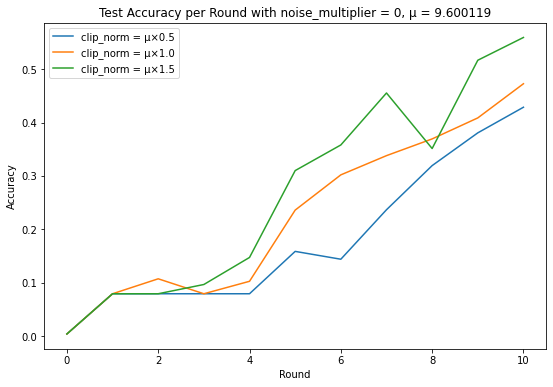

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
for i, hist in enumerate(hists_Q3):
  accuracy = hist.metrics_centralized['accuracy']
  rounds = list(zip(*accuracy))[0]
  acc = list(zip(*accuracy))[1]
  plt.plot(rounds, acc, label = "clip_norm = μ×" + str(clip_norms[i]/mean_l2))
  # for index in range(len(rounds)):
  #   ax.text(rounds[index], round(acc[index], 4), round(acc[index], 4))
plt.legend()
plt.title('Test Accuracy per Round with noise_multiplier = 0, μ = 9.600119')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.show()

From the plot, a larger bound of clip_norm leads to higher accuracy. To understand the reasons behind this, we need to examine the effects of bound. I analyze it from the perspectives of DP and FL.

From the perspective of fixed norm bound DP. The product of clip_norm bound and noise_multiplier determines the standard deviation of the added Gaussian noise. Thus, a larger bound leads to a higher L2 sensitivity as standard deviation needs to be proportional to L2 sensitivity in Gaussian noise. Andrew et al. [1] pointed that setting a clip_norm bound that is too high entails the addition of more noise, which will eventually destroy model utility.

From the perspective of FL, a lower clip_norm bound limits the divergence of highly heterogeneous clients because the bound is proportional to the model scaling factor, and we limit the scaling factor in the range of (0, 1). Thus, a lower clip_norm bound stabilizes training when combined with unweighted aggregation, but may come at the costs of reducing accuracy.

In this case, we set noise_multiplier = 0, which means the Gaussian noise is never effectively added. Thus, the positive correlation between the clip_norm bound and accuracy can be explained from the perspective of FL.

[1] https://arxiv.org/abs/1905.03871


**Question 4 (Part II ✅ | Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

This question extends the one above to investigate the effect that the `clip_norm` has upon the norm of the federated model update. The federated model update is defined as the difference between the model at the start of the round and the model post-aggregation.

1. Using the results from the above question, plot the following:

    *  The L2 norm of the federated model deltas across rounds for the three bounds above. How does L2 norm of the federated model delta compare to `clip_norm` (draw a horizontal line for all three bounds)? Is the behaviour as you expected, and why/why not?
    * The accuracy on the federated test set of models trained using the three norms above against the cumulative L2 norm accumulated across rounds as the axis. Consider the accuracy of the initial parameter test (round 0) to map to an L2 norm of 0. By cumulative L2, we mean a running sum where you keep adding the new norm value to the sum and then add the sum to a per-round list. Such a sum can easily be computed from a list using a `accumulate()` call.

2. How do the L2 norms of the federated model deltas compare against the change in accuracy between rounds? Is the relationship predictable and/or linear?  Consider all the `clip_norm` values you have tried in your response and provide potential explanations for why/why not the relationship between accuracy and cumulative L2 changes between bounds. 
  

**Question 4 Plots and Answer**

In [ ]:
for i, hist in enumerate(hists_Q3):
  print(hist.fit_metrics_distributed['l2_model_delta'])

[(1, 3.4735154552596854), (2, 3.1413647844400856), (3, 3.243159435046478), (4, 3.0549607649556743), (5, 3.069046091430751), (6, 2.9687540903981007), (7, 3.3070053526708736), (8, 3.377392778288275), (9, 3.4181965433849917), (10, 3.4574273266794364)]
[(1, 6.7341981614714195), (2, 4.944533632903363), (3, 5.382484581039704), (4, 5.322256293516981), (5, 6.028831019660606), (6, 7.075293889003668), (7, 6.94868885853355), (8, 7.1831089400801895), (9, 7.471407619841068), (10, 7.397472632674037)]
[(1, 6.993985746453119), (2, 5.482952593605501), (3, 7.49900832135448), (4, 7.120265083005594), (5, 8.086785456238307), (6, 9.170273214469022), (7, 7.558606588069089), (8, 8.383191421737537), (9, 7.572318749328624), (10, 7.988627552414503)]


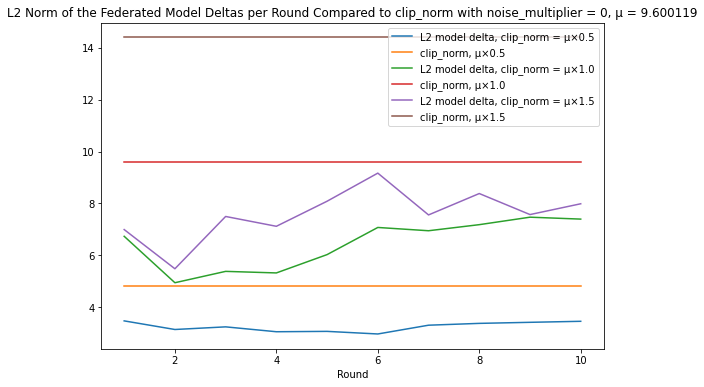

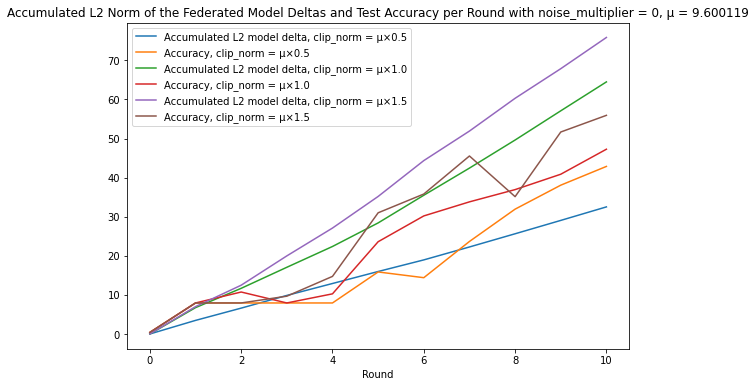

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
for i, hist in enumerate(hists_Q3):
  l2_model_delta = hist.fit_metrics_distributed['l2_model_delta']
  rounds = list(zip(*l2_model_delta))[0]
  clip_norm_list = [clip_norms[i]] * len(rounds)
  l2_model_delta = list(zip(*l2_model_delta))[1]
  plt.plot(rounds, l2_model_delta, label = "L2 model delta, clip_norm = μ×" + str(clip_norms[i]/mean_l2))
  plt.plot(rounds, clip_norm_list, label = "clip_norm, μ×" + str(clip_norms[i]/mean_l2))
  # for index in range(len(rounds)):
  #   ax.text(rounds[index], round(l2_model_delta[index], 4), round(l2_model_delta[index], 4))
plt.legend()
plt.title('L2 Norm of the Federated Model Deltas per Round Compared to clip_norm with noise_multiplier = 0, μ = 9.600119')
plt.xlabel('Round')
plt.ylabel('')
plt.show()


fig, ax = plt.subplots(figsize=(9, 6))
for i, hist in enumerate(hists_Q3):
  l2_model_delta = hist.fit_metrics_distributed['l2_model_delta']
  accuracy = hist.metrics_centralized['accuracy']
  rounds = list(zip(*accuracy))[0]
  l2_model_delta = list(zip(*l2_model_delta))[1]
  l2_model_delta_accumulated = np.asarray([0] + list(accumulate(l2_model_delta)))
  acc = np.asarray(list(zip(*accuracy))[1]) * 100
  plt.plot(rounds, l2_model_delta_accumulated, label = "Accumulated L2 model delta, clip_norm = μ×" + str(clip_norms[i]/mean_l2))
  plt.plot(rounds, acc, label = "Accuracy, clip_norm = μ×" + str(clip_norms[i]/mean_l2))
  # for index in range(len(rounds)):
  #   ax.text(rounds[index], round(acc[index], 4), round(acc[index], 4))
plt.legend()
plt.title('Accumulated L2 Norm of the Federated Model Deltas and Test Accuracy per Round with noise_multiplier = 0, μ = 9.600119')
plt.xlabel('Round')
plt.ylabel('')
plt.show()

**1.**

We can see that for all three values of clip_norm, they are the upper bound of L2 norm of the federated model delta. Also, a higher value of clip_norm bound leads a larger gap between the clip_norm and L2 norm of the federated model delta. 

The reason is for each client’s model update, we rescale the model weights using clip_norm bound divided by the model weights norm, and restrict in the range of (0, 1), so the clipped norm is at most the bound. Then, we apply unweighted averaging using all clients’ models without the addition of noises. Consequently, the norm of the aggregated model also falls below the bound, and the norm of the aggregated model of the next round and the norm of the aggregated model difference between consecutive rounds follow the same. 

\

**2.**

For accuracy curve, I multiply the values by 100 so that they fit in the same scale as the cumulative L2 norm of the federated model delta on the plot. However, it is worth to mention that accuracy has a theoretical upper bound (100%), but cumulative L2 norm does not. Thus, instead of focusing on the exact values of the two, analyzing their relationships will be more meaningful. 

We can see that for all three values of clip_norm, the cumulative L2 norm of the federated model delta linearly increase. Moreover, a higher clip_norm value results in larger slope and higher final value in both the cumulative L2 norm and accuracy, which means a higher cumulative L2 norm couples with a higher final accuracy and a larger cumulative L2 norm slope couples with a larger accuracy slope.

The positive correlations between the cumulative L2 norm and the accuracy in terms of final value and slope are actually not surprising. The slope of the accuracy curve indicates the convergence rate. Kairouz et al. [1, 2] made the key observation in their proposed DP-FTRL algorithm that “the convergence of SGD depends primarily not on the accuracy of individual gradients, but the accuracy of cumulative sums of gradients”. In this case, we can think of gradients as L2 norms. However, they did not offer a formal explanation for this observation. I hypothesize the reason is in addition to sensitivity, L2 norm of the federated delta can be understood as how fast the global model learns and updates, and the cumulative sum indicates the total amount of knowledge learned since model initialization. More learned knowledge is beneficial for the accuracy improvement.
	
To explain why the cumulative L2 norm of the federated model delta linearly increase, I think it may be due to the scaling factor of the model weights is inversely proportional to the model weights norm, so the global (federated) model update rate is almost linear.

[1] https://arxiv.org/abs/2103.00039 \
[2] https://ai.googleblog.com/2022/02/federated-learning-with-formal.html


## 3.2 Adaptive Norm Bound DP

Having investigated the impact of gradient clipping with a fixed norm on performance, you may wonder if your chosen norm will stay appropriate for the entire training. 

To avoid perfectly tuning a fixed `clip_norm` an [adaptive version of DPFedAvg](https://arxiv.org/abs/1905.03871) was proposed in paper \[3], which attempts to automatically scale the bound on the L2 norm of model updates based on a quantile of L2 norms provided by clients in a given round. As computing such a value would be computationally expensive and require clients to send private values, the paper proposes an algorithm meant to approximate the quantile.

Specifically, it adjusts the `clip_norm` parameter as:


>     self.clip_norm *= math.exp(-self.clip_norm_lr
            * (noised_clients_with_clipped_norm_fraction - self.clip_norm_target_quantile)
        )
 
where the new clip norm depends on a learning rate, the fraction of clients used in training who have clipped their norms (with added noise), and the target quantile. In the code below, the clients who have clipped their norm are reported via a set bit in the config, and thus `noised_clients_with_clipped_norm_fraction` is replaced with `noised_norm_bit_set_fraction`. By knowing approximately how many clients fall below a given norm, we can iteratively improve the `clip_norm` until the percentage of clients with norms smaller than the bound is reached.

The new implementation is hard to use and balance for short experiments such as ours as it includes an initial phase where the norm grows exponentially in its attempts to converge to the actual quantile. Given that we do not want any further interference making the behaviour of DP harder to predict, this would prove inconvenient when trying to deduce the impact of noise. As such, we shall only track the behaviour of the adaptive norm and use the predictable `DPFedAvgFixed` when experimenting with obtaining a given level of $\epsilon$ privacy.


In [ ]:
"""DP-FedAvg [Andrew et al., 2019] with adaptive clipping.
Paper: https://arxiv.org/pdf/1905.03871.pdf
"""
# Original implementation by Vasundhara Agarwal


import math
from typing import Dict, List, Optional, Tuple, Union

import numpy as np

from flwr.common import FitIns, FitRes, Parameters, Scalar
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.strategy import Strategy


class DPFedAvgAdaptive(DPFedAvgFixed):

    # pylint: disable=too-many-arguments,too-many-instance-attributes
    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = False,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        server_learning_rate: float = 1.0,
        server_momentum: float = 0.0,
        num_clients_per_round: int,
        init_clip_norm: float = 0.1,
        noise_multiplier: float = 1,
        server_side_noising: bool = True,
        clip_norm_lr: float = 0.2,
        clip_norm_target_quantile: float = 0.5,
        clip_count_stddev: Optional[float] = None,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
            server_learning_rate=server_learning_rate,
            server_momentum=server_momentum,
            num_clients_per_round=num_clients_per_round,
            clip_norm=init_clip_norm,
            noise_multiplier=noise_multiplier,
            server_side_noising=server_side_noising,
        )
        self.clip_norm_lr = clip_norm_lr
        self.clip_norm_target_quantile = clip_norm_target_quantile
        self.clip_count_stddev = clip_count_stddev

        # Decides the level of noise added to the fraction of clients which have clipped their norms
        if self.clip_count_stddev is None:
            self.clip_count_stddev = 0
            if noise_multiplier > 0:
                self.clip_count_stddev = self.num_clients_per_round / 20.0

        if noise_multiplier:
            self.noise_multiplier = (
                self.noise_multiplier ** (-2) - (2 * self.clip_count_stddev) ** (-2)
            ) ** (-0.5)

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""

        additional_config = {"dpfedavg_adaptive_clip_enabled": True}

        client_instructions = super().configure_fit(
            server_round, parameters, client_manager
        )

        for _, fit_ins in client_instructions:
            fit_ins.config.update(additional_config)

        return client_instructions

    def _update_clip_norm(self, results: List[Tuple[ClientProxy, FitRes]]) -> None:
        # Calculating number of clients which set the norm indicator bit
        norm_bit_set_count = 0
        for client_proxy, fit_res in results:
            if "dpfedavg_norm_bit" not in fit_res.metrics:
                raise Exception(
                    f"Indicator bit not returned by client with id {client_proxy.cid}."
                )
            if fit_res.metrics["dpfedavg_norm_bit"]:
                norm_bit_set_count += 1
        # Noising the count
        noised_norm_bit_set_count = float(
            np.random.normal(norm_bit_set_count, self.clip_count_stddev)
        )

        noised_norm_bit_set_fraction = noised_norm_bit_set_count / len(results)
        # Geometric update
        self.clip_norm *= math.exp(
            -self.clip_norm_lr
            * (noised_norm_bit_set_fraction - self.clip_norm_target_quantile)
        )

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not self.accept_failures and failures:
            return None, {}
        new_global_model, metrics = super().aggregate_fit(
            server_round, results, failures
        )
        self._update_clip_norm(results)
        metrics["adaptive_clip_norm"] = self.clip_norm
        return new_global_model, metrics


In [ ]:
# New function to run the adaptive norm experiments with sensible defaults

dp_client_generator = get_DP_client_generator(
    network_generator_cnn, data_dir, federated_partition, lambda x: df.cid[x]
)


adaptive_default_parameters: Dict = {
    "train_config": get_default_train_config(),
    "test_config": get_default_test_config(),
    "num_total_clients": num_total_clients,
    "num_clients_per_round": 4,
    "num_evaluate_clients": 0,
    "num_evaluate": 0,
    "accept_failures": False,
    "min_fit_clients": 2,
    "min_available_clients": 2,
    "initial_parameters": ndarrays_to_parameters(seed_model_cnn_params),
    "client_generator": dp_client_generator,
    "seed": Seeds.DEFAULT,
    "num_rounds": 10,
    "strategy": DPFedAvgAdaptive,
    "fed_eval": True,
    "server_side_noising": True,
    "clip_count_stddev": None,
}


def run_DP_adaptive_fl(
    noise_multiplier: float = 0,
    init_clip_norm: float = 2,
    clip_norm_lr: float = 0.2,
    clip_norm_target_quantile: float = 0.5,
    default_parameters=adaptive_default_parameters,
    **kwargs
):
    parameters: Dict = {**default_parameters, **kwargs}

    on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: parameters[
        "train_config"
    ]
    on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: parameters["test_config"]  # type: ignore

    fraction_fit: float = (
        float(parameters["num_clients_per_round"]) / parameters["num_total_clients"]
    )
    fraction_evaluate: float = (
        float(parameters["num_evaluate_clients"]) / parameters["num_total_clients"]
    )

    client_resources = {
        "num_gpus": 1.0 / 2.0
        if get_device() == "cuda"
        else 0.0,  # maximum amount of resources that a client can take
        "num_cpus": 1,
    }

    strategy = parameters["strategy"](
        num_clients_per_round=parameters["num_clients_per_round"],
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=parameters["min_fit_clients"],
        min_available_clients=parameters["min_available_clients"],
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        initial_parameters=parameters["initial_parameters"],
        accept_failures=parameters["accept_failures"],
        evaluate_fn=federated_evaluation_function
        if parameters["fed_eval"] is True
        else None,
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        init_clip_norm=init_clip_norm,
        clip_norm_lr=clip_norm_lr,
        clip_norm_target_quantile=clip_norm_target_quantile,
        noise_multiplier=noise_multiplier,
        server_side_noising=parameters["server_side_noising"],
        clip_count_stddev=parameters["clip_count_stddev"],
    )
    client_manager = CustomClientManager(criterion=None, seed=parameters["seed"])
    server = Server(
        client_manager=client_manager,
        strategy=strategy,
    )
    return start_seeded_simulation(
        client_fn=parameters["client_generator"],
        num_clients=parameters["num_total_clients"],
        client_resources=client_resources,
        server=server,
        config=ServerConfig(num_rounds=parameters["num_rounds"]),
        strategy=strategy,
        seed=parameters["seed"],
        name=f"adaptive_target_{clip_norm_target_quantile}_init_clip_norm_{init_clip_norm}_lr_{clip_norm_lr}_noise_{noise_multiplier}"
    )


In [ ]:
hist_adaptive_quantile_0_5 = run_DP_adaptive_fl(clip_norm_target_quantile=0.5, noise_multiplier=0)

WARNING flwr 2023-02-22 02:10:30,945 | app.py:187 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-02-22 02:10:31,031 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-02-22 02:10:35,166	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-22 02:10:37,915 | app.py:179 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7989158708.0, 'object_store_memory': 3994579353.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7989158708.0, 'object_store_memory': 3994579353.0}
INFO flwr 2023-02-22 02:10:38,019 | server.py:176 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-22 02:10:38,032 | server.py:35

Sampled the following clients:  ['1101', '2904', '2613', '3179']


DEBUG flwr 2023-02-22 02:11:17,575 | server.py:322 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 61.11it/s]
INFO flwr 2023-02-22 02:11:18,408 | server.py:209 | fit progress: (1, 191.28467798233032, {'accuracy': 0.07933333333333334}, 37.89773924400015)
INFO:flwr:fit progress: (1, 191.28467798233032, {'accuracy': 0.07933333333333334}, 37.89773924400015)
INFO flwr 2023-02-22 02:11:18,415 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 02:11:18,429 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:11:18,433 | server.py:308 | fit_round 2: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1418', '27', '1758', '410']


DEBUG flwr 2023-02-22 02:11:54,667 | server.py:322 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.29it/s]
INFO flwr 2023-02-22 02:11:56,076 | server.py:209 | fit progress: (2, 187.90929698944092, {'accuracy': 0.07933333333333334}, 75.56583093399968)
INFO:flwr:fit progress: (2, 187.90929698944092, {'accuracy': 0.07933333333333334}, 75.56583093399968)
INFO flwr 2023-02-22 02:11:56,079 | server.py:256 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
INFO flwr 2023-02-22 02:11:56,092 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:11:56,099 | server.py:308 | fit_round 3: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2215', '1477', '3146', '993']


DEBUG flwr 2023-02-22 02:12:36,502 | server.py:322 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 34.39it/s]
INFO flwr 2023-02-22 02:12:37,965 | server.py:209 | fit progress: (3, 179.8387167453766, {'accuracy': 0.07933333333333334}, 117.45410803400046)
INFO:flwr:fit progress: (3, 179.8387167453766, {'accuracy': 0.07933333333333334}, 117.45410803400046)
INFO flwr 2023-02-22 02:12:37,971 | server.py:256 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
INFO flwr 2023-02-22 02:12:37,995 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:12:38,005 | server.py:308 | fit_round 4: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2955', '1583', '580', '779']


DEBUG flwr 2023-02-22 02:13:18,443 | server.py:322 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 36.72it/s]
INFO flwr 2023-02-22 02:13:19,826 | server.py:209 | fit progress: (4, 173.82172012329102, {'accuracy': 0.07933333333333334}, 159.3153277020001)
INFO:flwr:fit progress: (4, 173.82172012329102, {'accuracy': 0.07933333333333334}, 159.3153277020001)
INFO flwr 2023-02-22 02:13:19,829 | server.py:256 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
INFO flwr 2023-02-22 02:13:19,859 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:13:19,866 | server.py:308 | fit_round 5: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1656', '1717', '1348', '261']


DEBUG flwr 2023-02-22 02:14:09,190 | server.py:322 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 24.69it/s]
INFO flwr 2023-02-22 02:14:11,181 | server.py:209 | fit progress: (5, 166.8597846031189, {'accuracy': 0.07933333333333334}, 210.67103201999998)
INFO:flwr:fit progress: (5, 166.8597846031189, {'accuracy': 0.07933333333333334}, 210.67103201999998)
INFO flwr 2023-02-22 02:14:11,185 | server.py:256 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
INFO flwr 2023-02-22 02:14:11,234 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:14:11,244 | server.py:308 | fit_round 6: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['346', '2627', '2817', '1058']


DEBUG flwr 2023-02-22 02:14:51,699 | server.py:322 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 63.78it/s]
INFO flwr 2023-02-22 02:14:52,497 | server.py:209 | fit progress: (6, 164.90532779693604, {'accuracy': 0.07933333333333334}, 251.98645897700044)
INFO:flwr:fit progress: (6, 164.90532779693604, {'accuracy': 0.07933333333333334}, 251.98645897700044)
INFO flwr 2023-02-22 02:14:52,503 | server.py:256 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
INFO flwr 2023-02-22 02:14:52,529 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:14:52,533 | server.py:308 | fit_round 7: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2251', '159', '3062', '2996']


DEBUG flwr 2023-02-22 02:15:42,065 | server.py:322 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 56.93it/s]
INFO flwr 2023-02-22 02:15:42,950 | server.py:209 | fit progress: (7, 159.9423644542694, {'accuracy': 0.07933333333333334}, 302.4399184690001)
INFO:flwr:fit progress: (7, 159.9423644542694, {'accuracy': 0.07933333333333334}, 302.4399184690001)
INFO flwr 2023-02-22 02:15:42,955 | server.py:256 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
INFO flwr 2023-02-22 02:15:42,977 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:15:42,982 | server.py:308 | fit_round 8: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2411', '528', '943', '725']


DEBUG flwr 2023-02-22 02:16:29,039 | server.py:322 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 34.46it/s]
INFO flwr 2023-02-22 02:16:30,519 | server.py:209 | fit progress: (8, 158.64968371391296, {'accuracy': 0.13266666666666665}, 350.00817531400025)
INFO:flwr:fit progress: (8, 158.64968371391296, {'accuracy': 0.13266666666666665}, 350.00817531400025)
INFO flwr 2023-02-22 02:16:30,522 | server.py:256 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
INFO flwr 2023-02-22 02:16:30,563 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:16:30,569 | server.py:308 | fit_round 9: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1850', '249', '2079', '1864']


DEBUG flwr 2023-02-22 02:17:05,712 | server.py:322 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 62.03it/s]
INFO flwr 2023-02-22 02:17:06,526 | server.py:209 | fit progress: (9, 147.2970986366272, {'accuracy': 0.276}, 386.0158214109997)
INFO:flwr:fit progress: (9, 147.2970986366272, {'accuracy': 0.276}, 386.0158214109997)
INFO flwr 2023-02-22 02:17:06,530 | server.py:256 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
INFO flwr 2023-02-22 02:17:06,554 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:17:06,557 | server.py:308 | fit_round 10: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2777', '82', '2583', '2652']


DEBUG flwr 2023-02-22 02:17:45,755 | server.py:322 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 32.32it/s]
INFO flwr 2023-02-22 02:17:47,298 | server.py:209 | fit progress: (10, 131.73117876052856, {'accuracy': 0.334}, 426.78804121600024)
INFO:flwr:fit progress: (10, 131.73117876052856, {'accuracy': 0.334}, 426.78804121600024)
INFO flwr 2023-02-22 02:17:47,301 | server.py:256 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
INFO flwr 2023-02-22 02:17:47,306 | server.py:237 | FL finished in 426.7951894600001
INFO:flwr:FL finished in 426.7951894600001
INFO flwr 2023-02-22 02:17:47,309 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 02:17:47,313 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results in hist object': [1, 1]}
INFO

Having gone through this slight detour to understand how we could obtain an adaptive bound which leaves the privacy budget mostly undisturbed without experimentation, we shall return to DP's primary goal, matching a given theoretical bound on privacy. However, Part III and MPHil students will now get to play around and observe the behaviour of this adaptive norm algorithm.

**Question 5 (Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

You will now examine the accuracy of adaptive norm clipping compared to the previously fixed norm clipping.

1. Using values of `clip_norm_target_quantile`$\in \{0.25,\, 0.5, \,0.75\}$ (you should already have results for the default value from the cells above. If you have lost it, look into the `histories` folder). Run `DPFedAvgAdaptive` experiments with the same parameters as the above example using a `noise_multiplier=0`. 
2. Plot the per-round accuracy on the federated test set of models trained using the three quantile targets above. Which quantile target converges the fastest and to the highest final accuracy, and why do you think that is? Are the results as conclusive as the fixed bound ones? **Hint**: consider the exponential nature of the bound adaptation.
3. Do an ordered pairwise comparison between the plots of per-round accuracy of the previous three `clip_norm` results for the fixed norm experiments against the adaptive norm experiments. I.e., plot `clip_norm=mean*0.5` against `clip_norm_target_quantile=0.25`, `clip_norm=mean` against `clip_norm_target_quantile=0.5`, and `clip_norm=mean` against `clip_norm_target_quantile=0.75`. How does each of the pairs compare? Where are the differences most pronounced, and why do you think that is?

**Question 5 Code**

In [ ]:
quantiles =[0.25, 0.5, 0.75]

In [ ]:
hists_Q4 = []
for quantile in quantiles:
  hists_Q4.append(run_DP_adaptive_fl(clip_norm_target_quantile=quantile, noise_multiplier=0))
  print("Quantile ", quantile, " finished")

WARNING flwr 2023-02-22 01:46:37,363 | app.py:187 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-02-22 01:46:37,442 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-02-22 01:46:41,017	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-22 01:46:42,531 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'object_store_memory': 3993295257.0, 'node:172.28.0.12': 1.0, 'memory': 7986590516.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'object_store_memory': 3993295257.0, 'node:172.28.0.12': 1.0, 'memory': 7986590516.0}
INFO flwr 2023-02-22 01:46:42,570 | server.py:176 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-22 01:46:42,583 | server.py:35

Sampled the following clients:  ['1101', '2904', '2613', '3179']


DEBUG flwr 2023-02-22 01:47:23,518 | server.py:322 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.40it/s]
INFO flwr 2023-02-22 01:47:24,935 | server.py:209 | fit progress: (1, 191.28468322753906, {'accuracy': 0.07933333333333334}, 41.39803795099988)
INFO:flwr:fit progress: (1, 191.28468322753906, {'accuracy': 0.07933333333333334}, 41.39803795099988)
INFO flwr 2023-02-22 01:47:24,940 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 01:47:24,950 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:47:24,961 | server.py:308 | fit_round 2: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1418', '27', '1758', '410']


DEBUG flwr 2023-02-22 01:48:08,725 | server.py:322 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 64.43it/s]
INFO flwr 2023-02-22 01:48:09,511 | server.py:209 | fit progress: (2, 188.11178541183472, {'accuracy': 0.07933333333333334}, 85.97312742500026)
INFO:flwr:fit progress: (2, 188.11178541183472, {'accuracy': 0.07933333333333334}, 85.97312742500026)
INFO flwr 2023-02-22 01:48:09,517 | server.py:256 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
INFO flwr 2023-02-22 01:48:09,527 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:48:09,538 | server.py:308 | fit_round 3: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2215', '1477', '3146', '993']


DEBUG flwr 2023-02-22 01:48:47,526 | server.py:322 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 37.14it/s]
INFO flwr 2023-02-22 01:48:48,877 | server.py:209 | fit progress: (3, 180.93250131607056, {'accuracy': 0.07933333333333334}, 125.33975486100007)
INFO:flwr:fit progress: (3, 180.93250131607056, {'accuracy': 0.07933333333333334}, 125.33975486100007)
INFO flwr 2023-02-22 01:48:48,880 | server.py:256 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
INFO flwr 2023-02-22 01:48:48,909 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:48:48,918 | server.py:308 | fit_round 4: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2955', '1583', '580', '779']


DEBUG flwr 2023-02-22 01:49:27,414 | server.py:322 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 62.26it/s]
INFO flwr 2023-02-22 01:49:28,222 | server.py:209 | fit progress: (4, 175.71612668037415, {'accuracy': 0.07933333333333334}, 164.6845916729999)
INFO:flwr:fit progress: (4, 175.71612668037415, {'accuracy': 0.07933333333333334}, 164.6845916729999)
INFO flwr 2023-02-22 01:49:28,228 | server.py:256 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
INFO flwr 2023-02-22 01:49:28,239 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:49:28,248 | server.py:308 | fit_round 5: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1656', '1717', '1348', '261']


DEBUG flwr 2023-02-22 01:50:05,254 | server.py:322 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.02it/s]
INFO flwr 2023-02-22 01:50:06,684 | server.py:209 | fit progress: (5, 169.42787885665894, {'accuracy': 0.07933333333333334}, 203.14621983400002)
INFO:flwr:fit progress: (5, 169.42787885665894, {'accuracy': 0.07933333333333334}, 203.14621983400002)
INFO flwr 2023-02-22 01:50:06,692 | server.py:256 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
INFO flwr 2023-02-22 01:50:06,721 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:50:06,736 | server.py:308 | fit_round 6: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['346', '2627', '2817', '1058']


DEBUG flwr 2023-02-22 01:50:49,087 | server.py:322 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 61.15it/s]
INFO flwr 2023-02-22 01:50:49,926 | server.py:209 | fit progress: (6, 167.52285361289978, {'accuracy': 0.07933333333333334}, 246.38899702400022)
INFO:flwr:fit progress: (6, 167.52285361289978, {'accuracy': 0.07933333333333334}, 246.38899702400022)
INFO flwr 2023-02-22 01:50:49,931 | server.py:256 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
INFO flwr 2023-02-22 01:50:49,955 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:50:49,960 | server.py:308 | fit_round 7: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2251', '159', '3062', '2996']


DEBUG flwr 2023-02-22 01:51:41,705 | server.py:322 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 34.46it/s]
INFO flwr 2023-02-22 01:51:43,133 | server.py:209 | fit progress: (7, 161.75937581062317, {'accuracy': 0.08}, 299.59515784899986)
INFO:flwr:fit progress: (7, 161.75937581062317, {'accuracy': 0.08}, 299.59515784899986)
INFO flwr 2023-02-22 01:51:43,143 | server.py:256 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
INFO flwr 2023-02-22 01:51:43,195 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:51:43,199 | server.py:308 | fit_round 8: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2411', '528', '943', '725']


DEBUG flwr 2023-02-22 01:52:25,858 | server.py:322 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.06it/s]
INFO flwr 2023-02-22 01:52:27,287 | server.py:209 | fit progress: (8, 160.32855796813965, {'accuracy': 0.10133333333333333}, 343.7497887700001)
INFO:flwr:fit progress: (8, 160.32855796813965, {'accuracy': 0.10133333333333333}, 343.7497887700001)
INFO flwr 2023-02-22 01:52:27,290 | server.py:256 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
INFO flwr 2023-02-22 01:52:27,334 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:52:27,341 | server.py:308 | fit_round 9: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1850', '249', '2079', '1864']


DEBUG flwr 2023-02-22 01:53:08,287 | server.py:322 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 33.46it/s]
INFO flwr 2023-02-22 01:53:09,772 | server.py:209 | fit progress: (9, 153.26577615737915, {'accuracy': 0.2}, 386.234822765)
INFO:flwr:fit progress: (9, 153.26577615737915, {'accuracy': 0.2}, 386.234822765)
INFO flwr 2023-02-22 01:53:09,775 | server.py:256 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
INFO flwr 2023-02-22 01:53:09,826 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:53:09,835 | server.py:308 | fit_round 10: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2777', '82', '2583', '2652']
(scheduler +47m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 0.5}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-02-22 01:53:49,572 | server.py:322 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 63.40it/s]
INFO flwr 2023-02-22 01:53:50,368 | server.py:209 | fit progress: (10, 144.9812891483307, {'accuracy': 0.248}, 426.83040600899994)
INFO:flwr:fit progress: (10, 144.9812891483307, {'accuracy': 0.248}, 426.83040600899994)
INFO flwr 2023-02-22 01:53:50,377 | server.py:256 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
INFO flwr 2023-02-22 01:53:50,384 | server.py:237 | FL finished in 426.84643574500024
INFO:flwr:FL finished in 426.84643574500024
INFO flwr 2023-02-22 01:53:50,386 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 01:53:50,392 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results in hist object': [1, 1]}
INFO

Quantile  0.25  finished


2023-02-22 01:53:55,742	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-22 01:53:57,248 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 7986610176.0, 'CPU': 2.0, 'object_store_memory': 3993305088.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7986610176.0, 'CPU': 2.0, 'object_store_memory': 3993305088.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-02-22 01:53:57,477 | server.py:176 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-22 01:53:57,486 | server.py:359 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-02-22 01:53:57,492 | server.py:178 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 54.64it/s]
INFO flwr 2023-02-22 01:53:58,382 | server.py:181 | initial p

Sampled the following clients:  ['1101', '2904', '2613', '3179']


DEBUG flwr 2023-02-22 01:54:48,008 | server.py:322 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 62.29it/s]
INFO flwr 2023-02-22 01:54:48,819 | server.py:209 | fit progress: (1, 191.28604984283447, {'accuracy': 0.07933333333333334}, 50.426414831999864)
INFO:flwr:fit progress: (1, 191.28604984283447, {'accuracy': 0.07933333333333334}, 50.426414831999864)
INFO flwr 2023-02-22 01:54:48,822 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 01:54:48,831 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:54:48,839 | server.py:308 | fit_round 2: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1418', '27', '1758', '410']


DEBUG flwr 2023-02-22 01:55:29,655 | server.py:322 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 38.61it/s]
INFO flwr 2023-02-22 01:55:30,956 | server.py:209 | fit progress: (2, 187.89879846572876, {'accuracy': 0.07933333333333334}, 92.56340084099975)
INFO:flwr:fit progress: (2, 187.89879846572876, {'accuracy': 0.07933333333333334}, 92.56340084099975)
INFO flwr 2023-02-22 01:55:30,961 | server.py:256 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
INFO flwr 2023-02-22 01:55:30,987 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:55:30,993 | server.py:308 | fit_round 3: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2215', '1477', '3146', '993']


DEBUG flwr 2023-02-22 01:56:25,915 | server.py:322 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
100%|██████████| 47/47 [00:02<00:00, 21.00it/s]
INFO flwr 2023-02-22 01:56:28,254 | server.py:209 | fit progress: (3, 179.68052554130554, {'accuracy': 0.07933333333333334}, 149.86165303899998)
INFO:flwr:fit progress: (3, 179.68052554130554, {'accuracy': 0.07933333333333334}, 149.86165303899998)
INFO flwr 2023-02-22 01:56:28,275 | server.py:256 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
INFO flwr 2023-02-22 01:56:28,292 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:56:28,305 | server.py:308 | fit_round 4: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2955', '1583', '580', '779']


DEBUG flwr 2023-02-22 01:57:07,804 | server.py:322 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 36.35it/s]
INFO flwr 2023-02-22 01:57:09,181 | server.py:209 | fit progress: (4, 174.35028433799744, {'accuracy': 0.07933333333333334}, 190.78913238799987)
INFO:flwr:fit progress: (4, 174.35028433799744, {'accuracy': 0.07933333333333334}, 190.78913238799987)
INFO flwr 2023-02-22 01:57:09,186 | server.py:256 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
INFO flwr 2023-02-22 01:57:09,211 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:57:09,221 | server.py:308 | fit_round 5: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1656', '1717', '1348', '261']


DEBUG flwr 2023-02-22 01:57:51,527 | server.py:322 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 27.90it/s]
INFO flwr 2023-02-22 01:57:53,296 | server.py:209 | fit progress: (5, 167.72321271896362, {'accuracy': 0.07933333333333334}, 234.90400754699976)
INFO:flwr:fit progress: (5, 167.72321271896362, {'accuracy': 0.07933333333333334}, 234.90400754699976)
INFO flwr 2023-02-22 01:57:53,301 | server.py:256 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
INFO flwr 2023-02-22 01:57:53,369 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:57:53,371 | server.py:308 | fit_round 6: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['346', '2627', '2817', '1058']


DEBUG flwr 2023-02-22 01:59:05,575 | server.py:322 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 25.76it/s]
INFO flwr 2023-02-22 01:59:07,583 | server.py:209 | fit progress: (6, 167.38146686553955, {'accuracy': 0.07933333333333334}, 309.19032471499986)
INFO:flwr:fit progress: (6, 167.38146686553955, {'accuracy': 0.07933333333333334}, 309.19032471499986)
INFO flwr 2023-02-22 01:59:07,587 | server.py:256 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
INFO flwr 2023-02-22 01:59:07,645 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:59:07,665 | server.py:308 | fit_round 7: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2251', '159', '3062', '2996']


DEBUG flwr 2023-02-22 01:59:52,764 | server.py:322 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 26.23it/s]
INFO flwr 2023-02-22 01:59:54,642 | server.py:209 | fit progress: (7, 160.38966822624207, {'accuracy': 0.07933333333333334}, 356.24937399600003)
INFO:flwr:fit progress: (7, 160.38966822624207, {'accuracy': 0.07933333333333334}, 356.24937399600003)
INFO flwr 2023-02-22 01:59:54,658 | server.py:256 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
INFO flwr 2023-02-22 01:59:54,710 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 01:59:54,727 | server.py:308 | fit_round 8: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2411', '528', '943', '725']
(scheduler +54m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 0.5}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-02-22 02:00:41,035 | server.py:322 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 31.95it/s]
INFO flwr 2023-02-22 02:00:42,593 | server.py:209 | fit progress: (8, 158.93465852737427, {'accuracy': 0.10933333333333334}, 404.2009910509996)
INFO:flwr:fit progress: (8, 158.93465852737427, {'accuracy': 0.10933333333333334}, 404.2009910509996)
INFO flwr 2023-02-22 02:00:42,598 | server.py:256 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
INFO flwr 2023-02-22 02:00:42,631 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:00:42,636 | server.py:308 | fit_round 9: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1850', '249', '2079', '1864']


DEBUG flwr 2023-02-22 02:01:31,467 | server.py:322 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 33.59it/s]
INFO flwr 2023-02-22 02:01:32,956 | server.py:209 | fit progress: (9, 150.34578609466553, {'accuracy': 0.22466666666666665}, 454.5639275239996)
INFO:flwr:fit progress: (9, 150.34578609466553, {'accuracy': 0.22466666666666665}, 454.5639275239996)
INFO flwr 2023-02-22 02:01:32,959 | server.py:256 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
INFO flwr 2023-02-22 02:01:33,005 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:01:33,016 | server.py:308 | fit_round 10: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2777', '82', '2583', '2652']


DEBUG flwr 2023-02-22 02:02:35,680 | server.py:322 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.04it/s]
INFO flwr 2023-02-22 02:02:37,109 | server.py:209 | fit progress: (10, 133.26612091064453, {'accuracy': 0.32066666666666666}, 518.7165294799997)
INFO:flwr:fit progress: (10, 133.26612091064453, {'accuracy': 0.32066666666666666}, 518.7165294799997)
INFO flwr 2023-02-22 02:02:37,117 | server.py:256 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
INFO flwr 2023-02-22 02:02:37,120 | server.py:237 | FL finished in 518.7276605739999
INFO:flwr:FL finished in 518.7276605739999
INFO flwr 2023-02-22 02:02:37,124 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 02:02:37,125 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results in 

Quantile  0.5  finished


2023-02-22 02:02:45,555	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-22 02:02:47,046 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'object_store_memory': 3992253235.0, 'node:172.28.0.12': 1.0, 'memory': 7984506471.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'object_store_memory': 3992253235.0, 'node:172.28.0.12': 1.0, 'memory': 7984506471.0}
INFO flwr 2023-02-22 02:02:47,073 | server.py:176 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-22 02:02:47,083 | server.py:359 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-02-22 02:02:47,090 | server.py:178 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 50.74it/s]
INFO flwr 2023-02-22 02:02:48,045 | server.py:181 | initial p

Sampled the following clients:  ['1101', '2904', '2613', '3179']


DEBUG flwr 2023-02-22 02:03:34,416 | server.py:322 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.75it/s]
INFO flwr 2023-02-22 02:03:35,819 | server.py:209 | fit progress: (1, 191.28625011444092, {'accuracy': 0.07933333333333334}, 47.761101246999715)
INFO:flwr:fit progress: (1, 191.28625011444092, {'accuracy': 0.07933333333333334}, 47.761101246999715)
INFO flwr 2023-02-22 02:03:35,822 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 02:03:35,835 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:03:35,842 | server.py:308 | fit_round 2: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1418', '27', '1758', '410']


DEBUG flwr 2023-02-22 02:04:11,232 | server.py:322 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 45.96it/s]
INFO flwr 2023-02-22 02:04:12,314 | server.py:209 | fit progress: (2, 187.75388050079346, {'accuracy': 0.07933333333333334}, 84.25586895599963)
INFO:flwr:fit progress: (2, 187.75388050079346, {'accuracy': 0.07933333333333334}, 84.25586895599963)
INFO flwr 2023-02-22 02:04:12,317 | server.py:256 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
INFO flwr 2023-02-22 02:04:12,329 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:04:12,332 | server.py:308 | fit_round 3: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2215', '1477', '3146', '993']


DEBUG flwr 2023-02-22 02:04:57,736 | server.py:322 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 59.13it/s]
INFO flwr 2023-02-22 02:04:58,587 | server.py:209 | fit progress: (3, 178.02787828445435, {'accuracy': 0.07933333333333334}, 130.52883771300003)
INFO:flwr:fit progress: (3, 178.02787828445435, {'accuracy': 0.07933333333333334}, 130.52883771300003)
INFO flwr 2023-02-22 02:04:58,595 | server.py:256 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
INFO flwr 2023-02-22 02:04:58,607 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:04:58,615 | server.py:308 | fit_round 4: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2955', '1583', '580', '779']


DEBUG flwr 2023-02-22 02:05:40,820 | server.py:322 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 33.39it/s]
INFO flwr 2023-02-22 02:05:42,320 | server.py:209 | fit progress: (4, 171.92933630943298, {'accuracy': 0.07933333333333334}, 174.2618713339998)
INFO:flwr:fit progress: (4, 171.92933630943298, {'accuracy': 0.07933333333333334}, 174.2618713339998)
INFO flwr 2023-02-22 02:05:42,322 | server.py:256 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
INFO flwr 2023-02-22 02:05:42,352 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:05:42,362 | server.py:308 | fit_round 5: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1656', '1717', '1348', '261']


DEBUG flwr 2023-02-22 02:06:26,097 | server.py:322 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 50.74it/s]
INFO flwr 2023-02-22 02:06:27,087 | server.py:209 | fit progress: (5, 164.41301226615906, {'accuracy': 0.07933333333333334}, 219.02970118899975)
INFO:flwr:fit progress: (5, 164.41301226615906, {'accuracy': 0.07933333333333334}, 219.02970118899975)
INFO flwr 2023-02-22 02:06:27,093 | server.py:256 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
INFO flwr 2023-02-22 02:06:27,114 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:06:27,129 | server.py:308 | fit_round 6: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['346', '2627', '2817', '1058']


DEBUG flwr 2023-02-22 02:07:16,206 | server.py:322 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 62.04it/s]
INFO flwr 2023-02-22 02:07:17,022 | server.py:209 | fit progress: (6, 164.6062958240509, {'accuracy': 0.07933333333333334}, 268.9643840819999)
INFO:flwr:fit progress: (6, 164.6062958240509, {'accuracy': 0.07933333333333334}, 268.9643840819999)
INFO flwr 2023-02-22 02:07:17,028 | server.py:256 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
INFO flwr 2023-02-22 02:07:17,048 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:07:17,053 | server.py:308 | fit_round 7: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2251', '159', '3062', '2996']


DEBUG flwr 2023-02-22 02:07:54,729 | server.py:322 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 35.42it/s]
INFO flwr 2023-02-22 02:07:56,160 | server.py:209 | fit progress: (7, 154.85020661354065, {'accuracy': 0.118}, 308.10270959399986)
INFO:flwr:fit progress: (7, 154.85020661354065, {'accuracy': 0.118}, 308.10270959399986)
INFO flwr 2023-02-22 02:07:56,164 | server.py:256 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
INFO flwr 2023-02-22 02:07:56,199 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:07:56,206 | server.py:308 | fit_round 8: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2411', '528', '943', '725']


DEBUG flwr 2023-02-22 02:08:54,398 | server.py:322 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 29.74it/s]
INFO flwr 2023-02-22 02:08:56,079 | server.py:209 | fit progress: (8, 149.5666060447693, {'accuracy': 0.22333333333333333}, 368.02146053499973)
INFO:flwr:fit progress: (8, 149.5666060447693, {'accuracy': 0.22333333333333333}, 368.02146053499973)
INFO flwr 2023-02-22 02:08:56,085 | server.py:256 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
INFO flwr 2023-02-22 02:08:56,124 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:08:56,129 | server.py:308 | fit_round 9: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1850', '249', '2079', '1864']


DEBUG flwr 2023-02-22 02:09:36,060 | server.py:322 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 61.64it/s]
INFO flwr 2023-02-22 02:09:36,882 | server.py:209 | fit progress: (9, 130.9702353477478, {'accuracy': 0.2926666666666667}, 408.82457523799985)
INFO:flwr:fit progress: (9, 130.9702353477478, {'accuracy': 0.2926666666666667}, 408.82457523799985)
INFO flwr 2023-02-22 02:09:36,886 | server.py:256 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
INFO flwr 2023-02-22 02:09:36,911 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 02:09:36,918 | server.py:308 | fit_round 10: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2777', '82', '2583', '2652']


DEBUG flwr 2023-02-22 02:10:27,150 | server.py:322 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 59.62it/s]
INFO flwr 2023-02-22 02:10:27,995 | server.py:209 | fit progress: (10, 115.3097574710846, {'accuracy': 0.3893333333333333}, 459.9378061450002)
INFO:flwr:fit progress: (10, 115.3097574710846, {'accuracy': 0.3893333333333333}, 459.9378061450002)
INFO flwr 2023-02-22 02:10:28,001 | server.py:256 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
INFO flwr 2023-02-22 02:10:28,008 | server.py:237 | FL finished in 459.9506033920002
INFO:flwr:FL finished in 459.9506033920002
INFO flwr 2023-02-22 02:10:28,018 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 02:10:28,022 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results in hist

Quantile  0.75  finished


**Question 5 Plots and Answer**

In [ ]:
filenames = ['/hist_1677031828_adaptive_target_0.75_init_clip_norm_2_lr_0.2_noise_0.json', '/hist_1677031357_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json', '/hist_1677030830_adaptive_target_0.25_init_clip_norm_2_lr_0.2_noise_0.json']
filenames = filenames[::-1]
hists_Q4 = []
hists_Q4 = load_hist_object(filenames, hists_Q4)

In [ ]:
for i, hist in enumerate(hists_Q4):
  print(hist.metrics_centralized['accuracy'])

[(0, 0.004), (1, 0.07933333333333334), (2, 0.07933333333333334), (3, 0.07933333333333334), (4, 0.07933333333333334), (5, 0.07933333333333334), (6, 0.07933333333333334), (7, 0.08), (8, 0.10133333333333333), (9, 0.2), (10, 0.248)]
[(0, 0.004), (1, 0.07933333333333334), (2, 0.07933333333333334), (3, 0.07933333333333334), (4, 0.07933333333333334), (5, 0.07933333333333334), (6, 0.07933333333333334), (7, 0.07933333333333334), (8, 0.10933333333333334), (9, 0.22466666666666665), (10, 0.32066666666666666)]
[(0, 0.004), (1, 0.07933333333333334), (2, 0.07933333333333334), (3, 0.07933333333333334), (4, 0.07933333333333334), (5, 0.07933333333333334), (6, 0.07933333333333334), (7, 0.118), (8, 0.22333333333333333), (9, 0.2926666666666667), (10, 0.3893333333333333)]


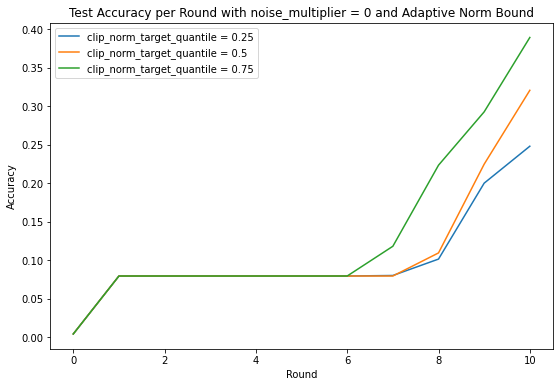

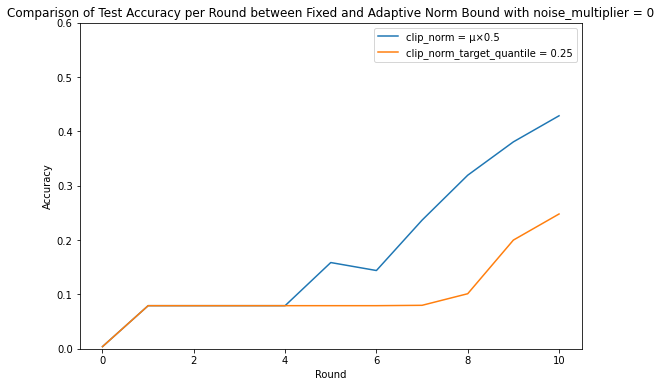

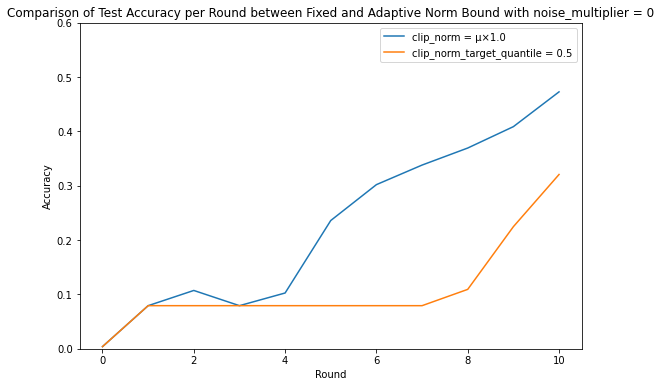

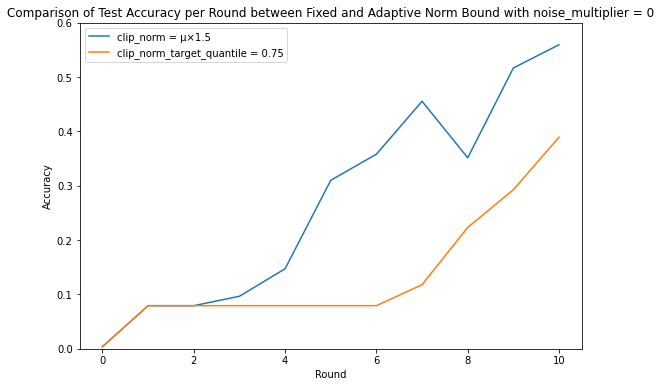

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
for i, hist in enumerate(hists_Q4):
  accuracy = hist.metrics_centralized['accuracy']
  rounds = list(zip(*accuracy))[0]
  acc = list(zip(*accuracy))[1]
  plt.plot(rounds, acc, label = "clip_norm_target_quantile = " + str(quantiles[i]))
  # for index in range(len(rounds)):
  #   ax.text(rounds[index], round(acc[index], 4), round(acc[index], 4))
plt.legend()
plt.title('Test Accuracy per Round with noise_multiplier = 0 and Adaptive Norm Bound')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.show()


for i, hist in enumerate(hists_Q4):
  fig, ax = plt.subplots(figsize=(9, 6))
  hist_clip_norm = hists_Q3[i]
  hist_quantile = hists_Q4[i]
  accuracy_clip_norm = hist_clip_norm.metrics_centralized['accuracy']
  accuracy_quantile = hist_quantile.metrics_centralized['accuracy']
  rounds = list(zip(*accuracy_clip_norm))[0]
  acc_clip_norm = list(zip(*accuracy_clip_norm))[1]
  acc_quantile = list(zip(*accuracy_quantile))[1]
  plt.plot(rounds, acc_clip_norm, label = "clip_norm = μ×" + str(clip_norms[i]/mean_l2))
  plt.plot(rounds, acc_quantile, label = "clip_norm_target_quantile = " + str(quantiles[i]))
  # for index in range(len(rounds)):
  #   ax.text(rounds[index], round(acc_clip_norm[index], 4), round(acc_clip_norm[index], 4))
  #   ax.text(rounds[index], round(acc_quantile[index], 4), round(acc_quantile[index], 4))
  plt.legend()
  plt.title('Comparison of Test Accuracy per Round between Fixed and Adaptive Norm Bound with noise_multiplier = 0')
  plt.xlabel('Round')
  plt.ylabel('Accuracy')
  plt.ylim(0, 0.6)
  plt.show()

**2.**

A larger quantile leads to a higher final accuracy after round 10. The accuracy curves of the three quantiles stay almost constant from round 1 to 6, and increase quite fast from round 6 to 10. 

Generally, a larger target quantile leads to a higher clip_norm bound during the online estimation of the norm distribution at each round. Since we set the noise noise_multiplier = 0 (similar to what we did in Question 3), the positive correlation between the target quantile and the final accuracy can be explained by my reasoning in Question 3. A lower adaptive clip_norm bound limits the divergence of highly heterogeneous clients, which stabilizes training when combined with unweighted aggregation, but may come at the costs of reducing accuracy.

The settling (at early rounds) and fast rate of increase (at late rounds) of the accuracy curve can be explained by the exponential nature of the geometric update rule. Although the geometric update rule “converges quickly to the true quantile even if the initial estimate is off by orders of magnitude” [1], in our case, the estimation has not converged to the true quantile yet. On the contrary, I hypothesize that the exponential property has just shown its power after round 6, so the accuracy skyrockets. Before round 6, the accuracy is trapped at the flat region of the exponential function.

Normally, it is hard to observe exponential rate or a very large slop in either accuracy curve or loss curve. However, the observations from this problem remind us it is possible. 


\

**3.**

The ordered comparison between the fixed norm bound the adaptive norm bound shows that higher accuracy curves are consistently achieve using fixed norm bounds. The initial gaps (from round 4 to 8) increase as clip_norm and quantile pairs increase, but the final gaps are relatively the same (gaps at round 10). I think it may due to two reasons. First, in this case, as we do not add noises, fixed norm bounds impose less limitation on the local updates compared to adaptive norm bounds because fixed norm bounds are larger in magnitude. This explains the higher final accuracy achieved by fixed norm bounds after round 10. Second, the decrease in gaps mean the accuracy curves of adaptive norm bound have higher rate of increase. As we only train for 10 rounds and the online estimation just starts to match the true quantile, the global model still needs more time to converge.

[1] https://arxiv.org/abs/1905.03871


**Question 6 (Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

This is an extension to the previous question, which tries to expand upon how the adaptive norm applied to client gradients/updates affects the L2 norm of the federated model delta.

1. Using the previous results for `clip_norm_target_quantile`$\in \{0.25,\, 0.5, \,0.75\}$, plot the L2 norm of the federated model delta for each target quantile. Which of the target quantiles causes the most considerable oscillations in the federated L2 norm, and why do you think that is?
2. Do a similar ordered pairwise comparison between the federated L2 norm results of the target quantile experiments against those of the fixed bound experiments as in the previous question. Where is the gap between the adaptive and fixed method the largest?
3. Plot the accuracy of experiments with the adaptive bounds against the cumulative L2 norm.

**Quesion 6 Plots**

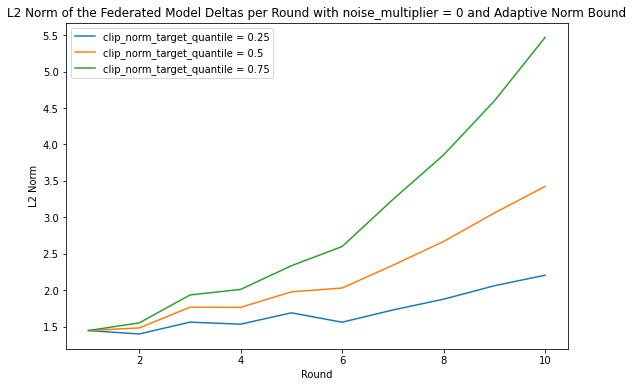

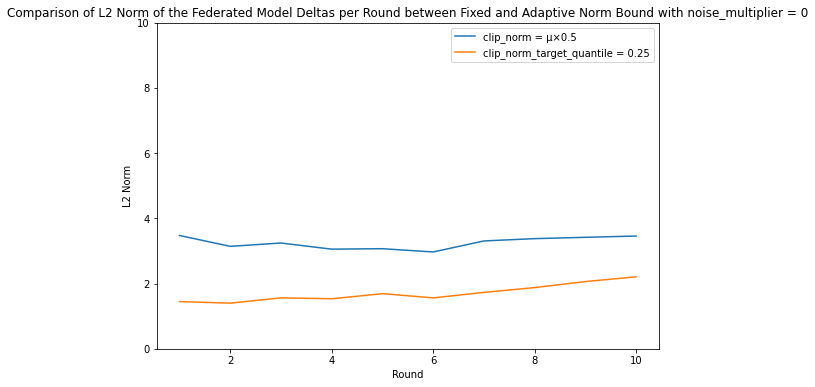

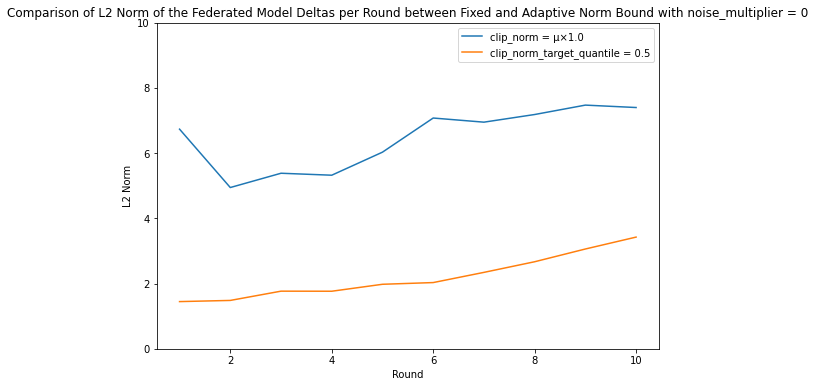

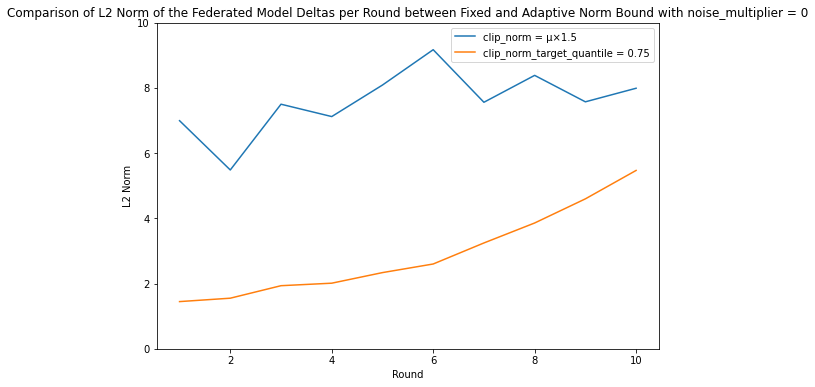

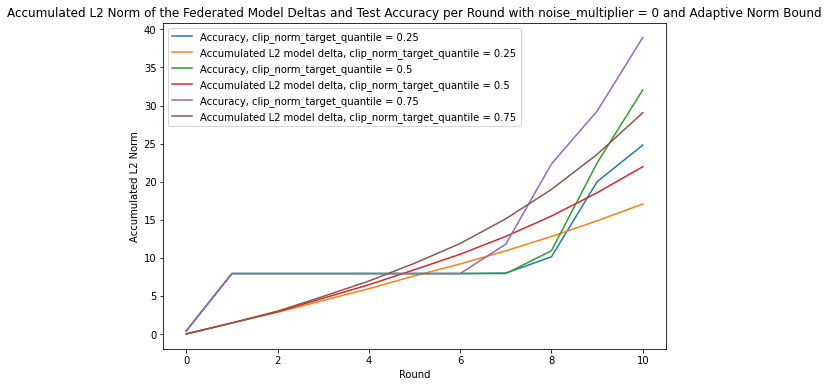

In [ ]:
# 1
fig, ax = plt.subplots(figsize=(9, 6))
for i, hist in enumerate(hists_Q4):
  l2_model_delta = hist.fit_metrics_distributed['l2_model_delta']
  rounds = list(zip(*l2_model_delta))[0]
  l2_model_delta = list(zip(*l2_model_delta))[1]
  plt.plot(rounds, l2_model_delta, label = "clip_norm_target_quantile = " + str(quantiles[i]))
  # for index in range(len(rounds)):
  #   ax.text(rounds[index], round(l2_model_delta[index], 4), round(l2_model_delta[index], 4))
plt.legend()
plt.title('L2 Norm of the Federated Model Deltas per Round with noise_multiplier = 0 and Adaptive Norm Bound')
plt.xlabel('Round')
plt.ylabel('L2 Norm')
plt.show()


# 2
for i, hist in enumerate(hists_Q4):
  fig, ax = plt.subplots(figsize=(9, 6))
  hist_clip_norm = hists_Q3[i]
  hist_quantile = hists_Q4[i]
  l2_clip_norm = hist_clip_norm.fit_metrics_distributed['l2_model_delta']
  l2_quantile = hist_quantile.fit_metrics_distributed['l2_model_delta']
  rounds = list(zip(*l2_clip_norm))[0]
  l2_clip_norm = list(zip(*l2_clip_norm))[1]
  l2_quantile = list(zip(*l2_quantile))[1]
  plt.plot(rounds, l2_clip_norm, label = "clip_norm = μ×" + str(clip_norms[i]/mean_l2))
  plt.plot(rounds, l2_quantile, label = "clip_norm_target_quantile = " + str(quantiles[i]))
  # for index in range(len(rounds)):
  #   ax.text(rounds[index], round(l2_clip_norm[index], 4), round(l2_clip_norm[index], 4))
  #   ax.text(rounds[index], round(l2_quantile[index], 4), round(l2_quantile[index], 4))
  plt.legend()
  plt.title('Comparison of L2 Norm of the Federated Model Deltas per Round between Fixed and Adaptive Norm Bound with noise_multiplier = 0')
  plt.xlabel('Round')
  plt.ylabel('L2 Norm')
  plt.ylim(0, 10)
  plt.show()


# 3
fig, ax = plt.subplots(figsize=(9, 6))
for i, hist in enumerate(hists_Q4):
  accuracy = hist.metrics_centralized['accuracy']
  l2_model_delta = hist.fit_metrics_distributed['l2_model_delta']
  rounds = list(zip(*accuracy))[0]
  acc = np.asarray(list(zip(*accuracy))[1]) * 100
  l2_model_delta = list(zip(*l2_model_delta))[1]
  l2_model_delta_accumulated = [0] + list(accumulate(l2_model_delta))
  plt.plot(rounds, acc, label = "Accuracy, clip_norm_target_quantile = " + str(quantiles[i]))
  plt.plot(rounds, l2_model_delta_accumulated, label = "Accumulated L2 model delta, clip_norm_target_quantile = " + str(quantiles[i]))
  # for index in range(len(rounds)):
  #   ax.text(rounds[index], round(l2_model_delta_accumulated[index], 4), round(l2_model_delta_accumulated[index], 4))
plt.legend()
plt.title('Accumulated L2 Norm of the Federated Model Deltas and Test Accuracy per Round with noise_multiplier = 0 and Adaptive Norm Bound')
plt.xlabel('Round')
plt.ylabel('Accumulated L2 Norm')
plt.show()

**Quesion 6 Answer**

**1.**

As the target quantile increases, the L2 norm of the federated model delta have both higher rate of increase and higher final value after round 10. The oscillations of the L2 norm of the federated model delta increase as target quantile decreases. 

The curve of the L2 norm of the federated model delta can be interpretated and explained in two ways in this case. First, it indicates the global model convergence rate. As a larger target quantile leads to a higher clip_norm bound and imposes less limitation on training, the global model convergence rate becomes higher. Second, it can be understood as how well the online estimation of the norm distribution matches the target quantile. A larger oscillation may be good because it means the estimation starts to settle around a value.

\

**2.**	

The comparison of the L2 norm of the federated model delta between the fixed norm bound and the adaptive norm bound shows that as clip_norm and quantile pairs increase, the size of the gap increases. I hypothesize it is because as target quantile increases, the true clip_norm calculated from the true quantile becomes more different from the initial clip_norm, which we set to 0.1 in all cases. To reach the true clip_norm, we need more geometric updates. The gaps seem to be large because we only train for 10 rounds. I think with more rounds of update, the size of the gaps will become smaller.

\


**3.**

We can see a larger target quantum results in a larger slope and higher final value in both the cumulative L2 norm of the federated model delta and the accuracy, which means a higher cumulative L2 norm couples with a higher final accuracy and a larger cumulative L2 norm slope couples with a larger accuracy slope. The reason is similar to my explanation in Question 4.2.


## 3.3 Epsilon-delta Privacy

We are now ready to understand the full extent of the DPFedAvg fixed algorithm and the relation between its privacy guarantees and the accuracy of the final model.

Prior to this, we should establish what a particular set of DP parameters imply for the level of privacy theoretically. The function below shall allow us to do just that while assuming a fixed number of rounds and clients per round. It adapts a function provided by TensorFlow privacy for DP-SgD, as we have established that DP-FedAvg and DP-SgD are equivalent when considering a mere reframing of samples as clients; it should provide sufficient accuracy for our purposes.  

In [ ]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import (
    apply_dp_sgd_analysis,
)
from contextlib import redirect_stdout
from io import StringIO


class NullIO(StringIO):
    def write(self, txt):
        pass


def compute_fl_privacy(
    num_rounds=10,
    noise_multiplier=1.0,
    num_total_clients=num_total_clients,
    num_fit_clients=4,
):

    q = num_fit_clients / num_total_clients  # q - the sampling ratio.

    # These orders are from compute_dp_sgd_privacy and they are needed 
    # For the estimation, do not concern yourselves with them
    orders = (
        [1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5, 4.0, 4.5]
        + list(range(5, 64))
        + [128, 256, 512]
    )

    with redirect_stdout(NullIO()):
        vals = apply_dp_sgd_analysis(
            q,
            sigma=noise_multiplier,
            steps=num_rounds,
            orders=orders,
            delta=num_total_clients ** (-1),
        )
    return vals[0]


In [ ]:
print(compute_fl_privacy(noise_multiplier=0.05))
print(compute_fl_privacy(noise_multiplier=0.1))


2195.207313171483
320.2353869685142


**Question 7 (Part II ✅ | Part III/MPhil ✅):**

(While this is a largely conceptual question, it does require you to provide a small amount of  **code** and several **plots**. Answers to the purely conceptual components should contain **no more than 5 sentences**.)

Using the function mentioned above, study the impact of different parameters on the privacy guarantees of DP-FedAvg as follows:

1. Draw a scatter plot with the epsilon value on the y-axis. While keeping all other parameters constant to the above values, vary the noise multiplier from 0.05 to 2 using an increment of 0.05. Use the noise multiplier as x-axis.

2. Draw a scatter plot with the epsilon value on the y-axis. While keeping all other parameters constant to the above values, vary `num_rounds` between $2^0$ and $2^{15}$ increasing using all the powers of two in the interval. Use the `num_rounds` as x-axis.

3. Draw a scatter plot with the epsilon value on the y-axis. While keeping all other parameters constant to the above values, vary `num_fit_cliets` from $2^0$ to $2^{10}$ increasing using all the powers of two in the interval. Use the `num_fit_cliets` as x-axis.

4. Describe the trade-offs you see and how they relate to FL privacy. Then, given the lecture by Peter Kairouz, what do you think the implications of these trade-offs are upon the practicality of Differential Privacy in FL?


Armed with this theoretical understanding of the privacy budget, we can explore the performance implications of Differential Privacy upon DPFedAvgFixed. Note once more that the experiments we are running are small scale, as such you may find particularly high sensitivity to the `noise_multiplier` to be present.

**Question 7 Plots and Answer**

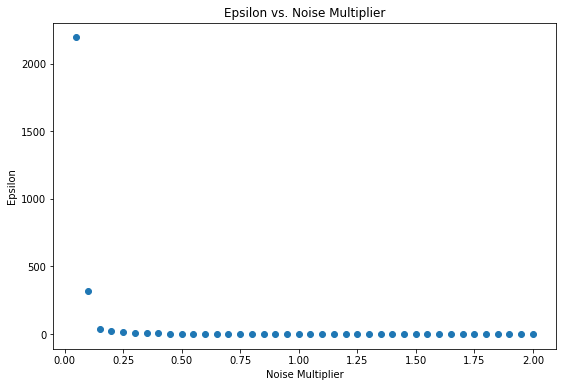

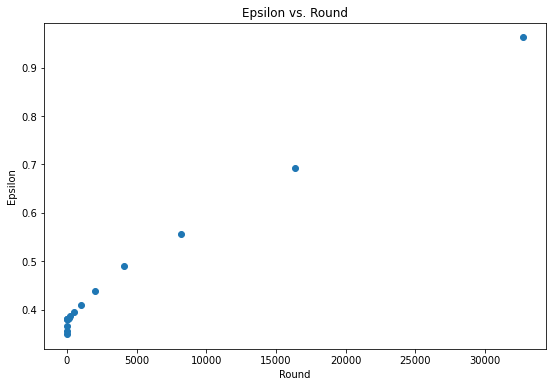

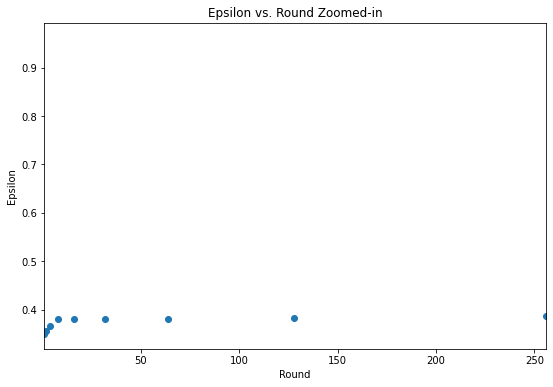

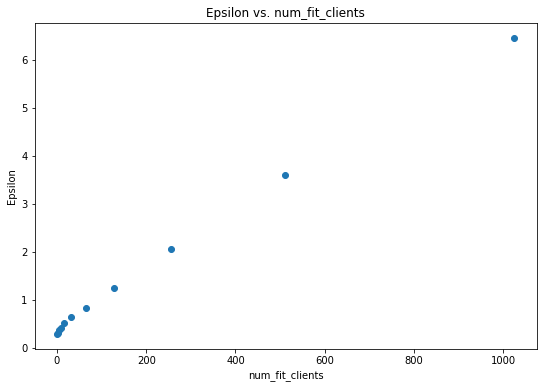

In [ ]:
# 1
noises = np.linspace(0.05, 2, int((2-0.05)/0.05)+1)
epsilons = [compute_fl_privacy(noise_multiplier=noise) for noise in noises]
fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(noises, epsilons)
plt.title('Epsilon vs. Noise Multiplier')
plt.xlabel('Noise Multiplier')
plt.ylabel('Epsilon')
plt.show()


# 2
rounds = [2**i for i in range(0, 15+1)]
epsilons = [compute_fl_privacy(num_rounds=rd) for rd in rounds]
fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(rounds, epsilons)
plt.title('Epsilon vs. Round')
plt.xlabel('Round')
plt.ylabel('Epsilon')
plt.show()

rounds = [2**i for i in range(0, 15+1)]
epsilons = [compute_fl_privacy(num_rounds=rd) for rd in rounds]
fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(rounds, epsilons)
plt.title('Epsilon vs. Round Zoomed-in')
plt.xlabel('Round')
plt.ylabel('Epsilon')
plt.xlim(2**0, 2**8)
plt.show()


# 3
num_clients = [2**i for i in range(0, 10+1)]
epsilons = [compute_fl_privacy(num_fit_clients=cl) for cl in num_clients]
fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(num_clients, epsilons)
plt.title('Epsilon vs. num_fit_clients')
plt.xlabel('num_fit_clients')
plt.ylabel('Epsilon')
plt.show()

As noise multiplier increases, the epsilon decreases exponentially with a large decay rate. Thus, an increase of the noise multiplier from 0.05 to [0.1, 0.15] can result in a large gain in privacy protection, and the marginal benefits decrease if we keep increasing the noise multiplier.

As the number of rounds increases, the epsilon increases relatively fast at first from round 1 to 8, stays almost constant at 0.40 from round 8 to 256, and increases at a lower rate from round 256 to 2^15. As a practical number of FL rounds can be scaled up to 1000 [1, 2, 3], we may be interested in developing techniques to achieve the same level of accuracy with lower FL rounds.

As the number of fit clients per round increases, the epsilon increases almost linearly. So it important for us to use the appropriate number of clients per round.

From the magnitude of the epsilon, we can see noise multiplier has the most significant effects on the value of epsilon followed by the number of fit clients per round, and finally the number of rounds.

The above observations can help us to set the reasonable training parameters for FL in a practical real-world application, but there are certainly more aspects to be considered. As Peter Kairouz discussed during the lecture, aspects such as privacy-accuracy trade-offs and computational costs are also crucial in a real production system.

[1] https://arxiv.org/abs/1602.05629 \
[2] https://arxiv.org/abs/2003.00295 \
[3] https://arxiv.org/abs/1905.03871


**Question 8 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Using the results of the previous experiment, observe the impact that a given noise multiplier has on both performance and privacy when using a **fixed** norm bound. 

1. Set a `noise_multiplier`$\in \{0.1\}$ while keeping all other parameters constant. Then run the FL simulation using the `DPFedAvgFixed` strategy from above.

2. Plot accuracy and compare the convergence curves against the results you have for the previous experiment with a multiplier of $0.05$ (`hist_clip_bound_4_noise_0_05`). *NOTE: it was done just after defining the aforementioned strategy.*

3. Use the `compute_fl_privacy` function to compute the epsilon value of two noise levels mentioned above. How does the epsilon of a given noise level relate to the accuracy achieved by that model? Does the relationship between the two fit your expectations from the question above? 
 


**Question 8 Code**

In [ ]:
filenames = ['/hist_1677102703_fixed_clip_norm_4_noise_0.05.json']
hist_clip_bound_4_noise_0_05 = []
hist_clip_bound_4_noise_0_05 = load_hist_object(filenames, hist_clip_bound_4_noise_0_05)[0]

filenames = ['/hist_1677103489_fixed_clip_norm_4_noise_0.1.json']
hist_Q8 = []
hist_Q8 = load_hist_object(filenames, hist_Q8)[0]

In [ ]:
hist_Q8 = run_DP_fixed_fl(clip_norm=4, noise_multiplier=0.1)

WARNING flwr 2023-02-22 21:56:29,491 | app.py:187 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-02-22 21:56:29,590 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-02-22 21:56:34,024	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-22 21:56:35,638 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3999827558.0, 'GPU': 1.0, 'memory': 7999655118.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3999827558.0, 'GPU': 1.0, 'memory': 7999655118.0}
INFO flwr 2023-02-22 21:56:35,688 | server.py:176 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-22 21:56:35,698 | server.py:35

Sampled the following clients:  ['1101', '2904', '2613', '3179']


DEBUG flwr 2023-02-22 21:57:13,226 | server.py:322 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 25.27it/s]
INFO flwr 2023-02-22 21:57:15,163 | server.py:209 | fit progress: (1, 185.8926064968109, {'accuracy': 0.04933333333333333}, 38.18702491800104)
INFO:flwr:fit progress: (1, 185.8926064968109, {'accuracy': 0.04933333333333333}, 38.18702491800104)
INFO flwr 2023-02-22 21:57:15,167 | server.py:256 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
INFO flwr 2023-02-22 21:57:15,181 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:57:15,195 | server.py:308 | fit_round 2: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1418', '27', '1758', '410']


DEBUG flwr 2023-02-22 21:58:01,579 | server.py:322 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 39.90it/s]
INFO flwr 2023-02-22 21:58:02,821 | server.py:209 | fit progress: (2, 179.00027537345886, {'accuracy': 0.068}, 85.84555649400136)
INFO:flwr:fit progress: (2, 179.00027537345886, {'accuracy': 0.068}, 85.84555649400136)
INFO flwr 2023-02-22 21:58:02,825 | server.py:256 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
INFO flwr 2023-02-22 21:58:02,842 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:58:02,853 | server.py:308 | fit_round 3: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2215', '1477', '3146', '993']
(scheduler +4h16m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 0.5}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-02-22 21:58:53,180 | server.py:322 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 62.89it/s]
INFO flwr 2023-02-22 21:58:53,991 | server.py:209 | fit progress: (3, 174.77269768714905, {'accuracy': 0.092}, 137.01519614000063)
INFO:flwr:fit progress: (3, 174.77269768714905, {'accuracy': 0.092}, 137.01519614000063)
INFO flwr 2023-02-22 21:58:53,998 | server.py:256 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
INFO flwr 2023-02-22 21:58:54,007 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:58:54,013 | server.py:308 | fit_round 4: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2955', '1583', '580', '779']


DEBUG flwr 2023-02-22 21:59:34,160 | server.py:322 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 23.68it/s]
INFO flwr 2023-02-22 21:59:36,234 | server.py:209 | fit progress: (4, 179.73610711097717, {'accuracy': 0.088}, 179.25848949400097)
INFO:flwr:fit progress: (4, 179.73610711097717, {'accuracy': 0.088}, 179.25848949400097)
INFO flwr 2023-02-22 21:59:36,246 | server.py:256 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
INFO flwr 2023-02-22 21:59:36,281 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 21:59:36,295 | server.py:308 | fit_round 5: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1656', '1717', '1348', '261']


DEBUG flwr 2023-02-22 22:00:38,512 | server.py:322 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 29.96it/s]
INFO flwr 2023-02-22 22:00:40,153 | server.py:209 | fit progress: (5, 203.32893753051758, {'accuracy': 0.10533333333333333}, 243.1777019400015)
INFO:flwr:fit progress: (5, 203.32893753051758, {'accuracy': 0.10533333333333333}, 243.1777019400015)
INFO flwr 2023-02-22 22:00:40,158 | server.py:256 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
INFO flwr 2023-02-22 22:00:40,193 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 22:00:40,214 | server.py:308 | fit_round 6: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['346', '2627', '2817', '1058']


DEBUG flwr 2023-02-22 22:01:37,507 | server.py:322 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 32.32it/s]
INFO flwr 2023-02-22 22:01:39,039 | server.py:209 | fit progress: (6, 226.0011146068573, {'accuracy': 0.08333333333333333}, 302.0639246720002)
INFO:flwr:fit progress: (6, 226.0011146068573, {'accuracy': 0.08333333333333333}, 302.0639246720002)
INFO flwr 2023-02-22 22:01:39,044 | server.py:256 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
INFO flwr 2023-02-22 22:01:39,077 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 22:01:39,082 | server.py:308 | fit_round 7: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2251', '159', '3062', '2996']


DEBUG flwr 2023-02-22 22:02:26,352 | server.py:322 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
100%|██████████| 47/47 [00:02<00:00, 22.85it/s]
INFO flwr 2023-02-22 22:02:28,479 | server.py:209 | fit progress: (7, 209.2875988483429, {'accuracy': 0.06266666666666666}, 351.50390666900057)
INFO:flwr:fit progress: (7, 209.2875988483429, {'accuracy': 0.06266666666666666}, 351.50390666900057)
INFO flwr 2023-02-22 22:02:28,483 | server.py:256 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
INFO flwr 2023-02-22 22:02:28,535 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 22:02:28,546 | server.py:308 | fit_round 8: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2411', '528', '943', '725']


DEBUG flwr 2023-02-22 22:03:20,419 | server.py:322 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 27.10it/s]
INFO flwr 2023-02-22 22:03:22,276 | server.py:209 | fit progress: (8, 185.56166768074036, {'accuracy': 0.132}, 405.3008851499999)
INFO:flwr:fit progress: (8, 185.56166768074036, {'accuracy': 0.132}, 405.3008851499999)
INFO flwr 2023-02-22 22:03:22,280 | server.py:256 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
INFO flwr 2023-02-22 22:03:22,316 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 22:03:22,324 | server.py:308 | fit_round 9: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['1850', '249', '2079', '1864']
(scheduler +4h22m0s) Warning: The following resource request cannot be scheduled right now: {'GPU': 0.5, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-02-22 22:04:07,535 | server.py:322 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 60.97it/s]
INFO flwr 2023-02-22 22:04:08,371 | server.py:209 | fit progress: (9, 187.43933176994324, {'accuracy': 0.11066666666666666}, 451.3951450860004)
INFO:flwr:fit progress: (9, 187.43933176994324, {'accuracy': 0.11066666666666666}, 451.3951450860004)
INFO flwr 2023-02-22 22:04:08,381 | server.py:256 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
INFO flwr 2023-02-22 22:04:08,402 | client_manager.py:49 | Sampling using None
INFO:flwr:Sampling using None
DEBUG flwr 2023-02-22 22:04:08,407 | server.py:308 | fit_round 10: strategy sampled 4 clients (out of 3224)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 3224)


Sampled the following clients:  ['2777', '82', '2583', '2652']


DEBUG flwr 2023-02-22 22:04:47,710 | server.py:322 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
100%|██████████| 47/47 [00:01<00:00, 37.01it/s]
INFO flwr 2023-02-22 22:04:49,077 | server.py:209 | fit progress: (10, 207.37319660186768, {'accuracy': 0.11866666666666667}, 492.1011717700003)
INFO:flwr:fit progress: (10, 207.37319660186768, {'accuracy': 0.11866666666666667}, 492.1011717700003)
INFO flwr 2023-02-22 22:04:49,082 | server.py:256 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
INFO flwr 2023-02-22 22:04:49,084 | server.py:237 | FL finished in 492.1088933350002
INFO:flwr:FL finished in 492.1088933350002
INFO flwr 2023-02-22 22:04:49,088 | app.py:202 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-02-22 22:04:49,092 | app.py:203 | app_fit: metrics_distributed {'Placeholder, see fit and eval metrics distributed results in 

In [ ]:
epsilon_noise_005 = compute_fl_privacy(num_rounds=default_parameters['num_rounds'], noise_multiplier=0.05, num_total_clients=num_total_clients, num_fit_clients=default_parameters['num_clients_per_round'])
epsilon_noise_010 = compute_fl_privacy(num_rounds=default_parameters['num_rounds'], noise_multiplier=0.1, num_total_clients=num_total_clients, num_fit_clients=default_parameters['num_clients_per_round'])
print(epsilon_noise_005)
print(epsilon_noise_010)

2195.207313171483
320.2353869685142


**Question 8 Plots and Answer**

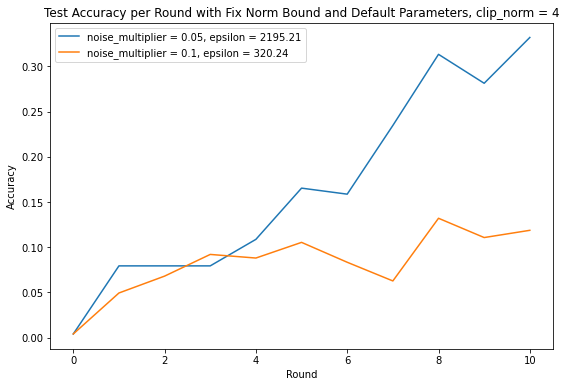

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
acc1 = hist_clip_bound_4_noise_0_05.metrics_centralized['accuracy']
acc2 = hist_Q8.metrics_centralized['accuracy']
rounds = list(zip(*acc1))[0]
acc1 = list(zip(*acc1))[1]
acc2 = list(zip(*acc2))[1]
plt.plot(rounds, acc1, label = "noise_multiplier = 0.05, epsilon = 2195.21")
plt.plot(rounds, acc2, label = "noise_multiplier = 0.1, epsilon = 320.24")
# for index in range(len(rounds)):
#   ax.text(rounds[index], round(acc1[index], 4), round(acc1[index], 4))
#   ax.text(rounds[index], round(acc2[index], 4), round(acc2[index], 4))
plt.legend()
plt.title('Test Accuracy per Round with Fix Norm Bound and Default Parameters, clip_norm = 4')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.show()

From the plot of using two different noise multipliers, we can clearly see a smaller noise multiplier (0.05) with larger epsilon (2195.21) leads to a higher accuracy than using a larger noise multiplier (0.1) with smaller epsilon (320.24). This behavior is expected and is known as privacy-accuracy trade-off, a concept that is widely revealed and researched in existing works related to DP [1] and FL-DP [2]. 

The negative correlation between privacy and accuracy is straightforward to understand. We add more noises to either gradients or model (depending on the level of DP) in order to increase the privacy guarantee, and more noises deteriorate the quality of the training, leading to a lower accuracy.

There are other elements which can affect the privacy-accuracy trade-off. For instance, as explained by Peter Kairouz during the lecture, a higher computation cost (e.g., larger batch size) and larger dataset size can lead to better privacy-accuracy trade-offs.

[1] https://arxiv.org/abs/1710.06963 \
[2] https://arxiv.org/abs/2103.00039


# Secure Aggregation

In this section, we will explore a Secure Multi-Party Computation (SMPC) based approach first implemented in an FL context in [this](https://arxiv.org/abs/1611.04482) paper, called Secure Aggregation.
The authors proposed a protocol for the secure aggregation of model updates in a Federated Learning setting.
SMPC algorithms allow a group of mutually distrustful parties to compute a function over their private inputs without revealing any information about their inputs to one another.
In Federated Learning, users can compute the average of their model updates without revealing any information about their model updates to the other actors.
This is achieved by a complex exchange of encrypted keys and messages between the actors, which is why the protocol is computationally expensive.
The additional information the server and clients exchanges results in additional communication overhead.
In this Lab, we will focus on the communication overhead, ignoring the computational overhead. Furthermore, the protocol requires a specific fraction of clients to complete training to compute the average.

Pan Heng did the first implementation of Secure Aggregation in Flower. Thus we will use part of his code in this section. However, because of the complexity of this protocol, we refer all the discussions to the original paper.
The main takeaways from the paper are the following: private inputs of clients are completely protected in this setting; Secure Aggregation is computationally expensive and requires a lot of communication overhead; the scalability of Secure Aggregation to many clients requires a lot of computational resources.

In the following cell, we will download the code for the Secure Aggregation protocol.

In [ ]:
# Create the folder for the Secure Aggregation files
secagg_dir = home_dir / "secagg"
if not secagg_dir.exists():
    secagg_dir.mkdir()
# Download the scripts
if not (secagg_dir / "client_class.py").exists():
    id = "1CXVYyKqnCePf71WsVPO79C2MEs_RvUv6"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(secagg_dir / "client_class.py"),
    )
if not (secagg_dir / "strategy_class.py").exists():
    id = "1CX4NtbIGyK1xqQgL2aasHx5wb4LdK2uG"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(secagg_dir / "strategy_class.py"),
    )
if not (secagg_dir / "secagg_utils.py").exists():
    id = "1CVD10Vz9toCtT68LbQIRXDzX-yuBZHeH"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(secagg_dir / "secagg_utils.py"),
    )

The implementation contains many encryption utilities, and thus it is very complex.
So, feel free to dig into the code, but be aware that it is unnecessary to understand every part of it to complete the Lab.

We also need to create a folder to store the keys generated on the fly by our simulation.

In [ ]:
# TODO: we may want to change the name of this folder
keys_dir = secagg_dir/'client_data'
if not keys_dir.exists():
    keys_dir.mkdir()

We are now importing the important functions for simulating the Secure Aggregation protocol from the files we have just downloaded.

In [ ]:
from secagg.client_class import get_client_generator
from secagg.strategy_class import SecureAggregationStrategy

It is important to point out that from now on we will use a toy simulator.
This means that we will not use real clients, so we are not training anything.
We will just simulate the communication between the server and the clients to explore the communication overhead.
The scripts are built to return to the `aggregate_fit` function of the server the length of the bytes exchanged during all the phases of communication of the Secure Aggregation protocol.
The equivalent single FL training round is achieved in 4 phases of communication by the protocol.

It is worth mentioning that for this implementation we will change our training round from using epochs to local steps because we need all the clients to train on the same amount of data samples.
This is done because even the number of samples could be considered sensitive information that we do not want to reveal to the other actors.

In [ ]:
def run_SA_demo(
    num_clients_per_round=10,
    n_model_parameters=10000,
    min_num_surviving_clients=10, # at least 3*num_clients_per_round/4
    n_rounds=2,
    n_samples=30,
    ):

    client_resources = {
        "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0, # maximum amount of resources that a client can take
        "num_cpus": 1,
    }

    strategy = SecureAggregationStrategy(
        n_dim=n_model_parameters,
        num_clients_per_round=num_clients_per_round,
        threshold=min_num_surviving_clients,
        num_dropouts=num_clients_per_round-min_num_surviving_clients,
    )
    # TODO: we may wan to change this to our client manager
    client_manager = SimpleClientManager()
    # client_manager = CustomClientManager(criterion=None, seed=Seeds.DEFAULT)

    server = Server(
        client_manager=client_manager,
        strategy=strategy,
    )
    secagg_hist = start_seeded_simulation(
        client_fn=get_client_generator(n_model_parameters, n_samples, keys_dir),
        num_clients=num_total_clients,
        client_resources=client_resources,
        server=server,
        config=ServerConfig(num_rounds=int(4*n_rounds)), # this refers to the number of phases to simulate (must be 4*n_rounds)
        strategy=strategy,
        name=f'secagg_{num_clients_per_round}_{n_model_parameters}_{min_num_surviving_clients}_{n_rounds}_{n_samples}',
    )
    
    # Clean up keys from the folder
    for filename in os.listdir(keys_dir):
        file_pth = keys_dir / filename
        if filename.endswith('.pth'):
            os.remove(file_pth)
    
    return secagg_hist

In the next cell, we will simulate the Secure Aggregation protocol defined by the abovementioned parameters.

In [ ]:
secagg_hist = run_SA_demo()

In [ ]:
secagg_hist

History (metrics, distributed, fit):
{'total_cost': [(1, 4500), (2, 79160), (3, 25), (4, 14430), (5, 4500), (6, 79160), (7, 25), (8, 14430)]}

Looking carefully at the `History` object returned by the simulation, we can see that it contains the key `total_cost`, which couples the round of communication with the number of bytes exchanged during that round.
Note that the values are periodic because of the 4 phases involved in the protocol.

**Question 9 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Using the function `run_SA_demo`, study the impact of different parameters on the `total_cost`:

1. Draw a scatter plot with the `total_cost` on the y-axis. While keeping all other parameters constant to the above values, vary the `num_clients_per_round` from 10 to 100 using an increment of 10. Use the `num_clients_per_round` as the x-axis.

2. Draw a scatter plot with the `total_cost` on the y-axis. While keeping all other parameters constant to the above values, vary `n_model_parameters` between $2^{13}$ and $2^{20}$ increasing using all the powers of two in the interval. Use the `n_model_parameters` as the x-axis.

3. Describe the trade-offs you see and how they relate to communication overheads.


**Question 9 Code**

In [ ]:
num_clients_per_rounds = np.arange(10, 100 + 10, 10)
hists_Q9_1 = []
for cl in num_clients_per_rounds:
  hists_Q9_1.append(run_SA_demo(num_clients_per_round=cl))

n_model_parameters = [2**i for i in range(13, 20+1)]
hists_Q9_2 = []
for params in n_model_parameters:
  hists_Q9_2.append(run_SA_demo(n_model_parameters=params))

In [44]:
filenames = ['/hist_1677163277_secagg_10_10000_5_2_30.json', '/hist_1677163341_secagg_20_10000_5_2_30.json', '/hist_1677163473_secagg_30_10000_5_2_30.json', '/hist_1677163642_secagg_40_10000_5_2_30.json', '/hist_1677163829_secagg_50_10000_5_2_30.json', '/hist_1677164073_secagg_60_10000_5_2_30.json', '/hist_1677164359_secagg_70_10000_5_2_30.json', '/hist_1677164727_secagg_80_10000_5_2_30.json', '/hist_1677165153_secagg_90_10000_5_2_30.json', '/hist_1677166337_secagg_100_10000_5_2_30.json']
hists_Q9_1 = []
hists_Q9_1 = load_hist_object(filenames, hists_Q9_1)

filenames = ['/hist_1677165193_secagg_10_8192_5_2_30.json', '/hist_1677165231_secagg_10_16384_5_2_30.json', '/hist_1677165271_secagg_10_32768_5_2_30.json', '/hist_1677165310_secagg_10_65536_5_2_30.json', '/hist_1677165360_secagg_10_131072_5_2_30.json', '/hist_1677165403_secagg_10_262144_5_2_30.json', '/hist_1677165445_secagg_10_524288_5_2_30.json', '/hist_1677165493_secagg_10_1048576_5_2_30.json']
hists_Q9_2 = []
hists_Q9_2 = load_hist_object(filenames, hists_Q9_2)

**Question 9 Plots and Answer**

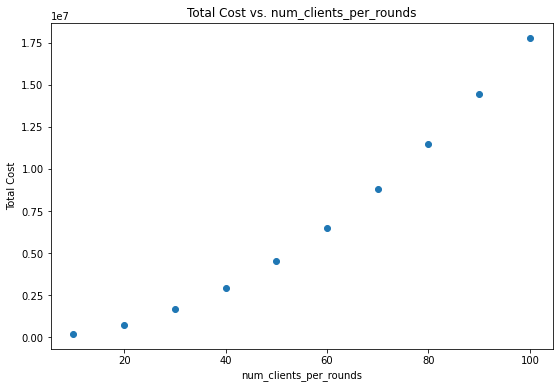

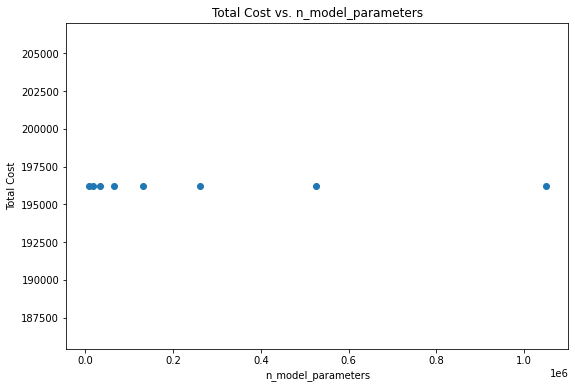

In [45]:
# 1
num_clients_per_rounds = np.arange(10, 100 + 10, 10)
total_cost = []
for hist in hists_Q9_1:
  total_cost_hist = hist.fit_metrics_distributed['total_cost']
  total_cost.append(np.sum(np.asarray([cost[1] for cost in total_cost_hist])))
fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(num_clients_per_rounds, total_cost)
plt.title('Total Cost vs. num_clients_per_rounds')
plt.xlabel('num_clients_per_rounds')
plt.ylabel('Total Cost')
plt.show()

2
n_model_parameters = [2**i for i in range(13, 20+1)]
total_cost = []
for hist in hists_Q9_2:
  total_cost_hist = hist.fit_metrics_distributed['total_cost']
  total_cost.append(np.sum(np.asarray([cost[1] for cost in total_cost_hist])))
fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(n_model_parameters, total_cost)
plt.title('Total Cost vs. n_model_parameters')
plt.xlabel('n_model_parameters')
plt.ylabel('Total Cost')
plt.show()

For the scatter plot, I take the sum of the total cost across rounds.

As the number of clients per rounds increases linearly, the total communication cost increases at a quadratic rate. More specially, the rate is O (n^2 + kn), resulting from the sending and broadcasting of the pairwise Diffie-Hellman keys of the practical secure aggregation protocol [1, 2], which I will explain in more depths in the following Question 10. 

As the number of model parameters increases exponentially, the total communication cost stays constant. This is because in the pairwise Diffie-Hellman key agreement used by the practical secure aggregation protocol [1, 2], the server only needs to broadcast a secret number (i.e., scalar) to all clients, which is independent of the length of model updates vectors. I will also explain in more details in the following Question 10. 

[1] https://arxiv.org/abs/1611.04482 \
[2] https://research.google/pubs/pub47246/


**Question 10 (Part II ✅ | Part III/MPhil ✅):**

(This is a purely conceptual question. Answer in **no more than 10 sentences each**.)

After reading the [paper](https://arxiv.org/abs/1611.04482) and experimenting with the additional communication costs of Secure Aggregation in FL, discuss the implication of using this protocol in a real FL setting. You may want to discriminate between cross-silo and cross-device settings. You can focus on communication and computation overheads and refer to the asymptotic complexity of both.


**Question 10 Answer**

The central goal of secure aggregation (SA) is to aggregate the updates from all clients without inspecting and revealing the sensitive information within the clients’ updates, where we assume a server that follows the protocol but is curious and can lie [1, 4].

Previous solutions of SA in the real FL setting suffer from two main problems, which either transit large amount of data (because clients’ updates are long vectors) and fail when clients drop out (in FL-SA, we typically adopt the cross-device setting in which edge devices can scale up to 10^10 [2]) because the pairwise generated user vector masks do not cancel out.

Practical SA [1, 4] solves the first problem using pairwise Diffie-Hellman key agreement, where the server only needs to broadcast a secret number (i.e., scalar) to all clients, which will then be used to seed a pseudorandom number generator and spawn paired antiparticle vectors [3]. The result is the protocol will not transmit twice more the amount of data compared to the amount of data we transmit without SA (i.e., bandwidth expansion always < 2x) [4]. Practical SA [1, 4] solves the second problem using k-out-of-n threshold secret sharing by breaking secret into n pieces, in which only ≥ k shares can interpolate the polynomials and recover the secrets perfectly [2].

\

The deployment of practical SA in cross-device FL is more difficult than cross-silo FL. I explain it with the following three reasons. 

First, for the k-out-of-n threshold secret sharing, though with enough number of honest clients and a threshold k that is high enough, the server cannot recover the secret, we face the issue where in a realistic network system, clients can appear to be dropped out but in fact they are just late. In this case, the server can recover the masks and updates of the dropped-out clients because it has already computed their privacy keys. Practical SA [1, 4] solves this by sharing additional individual keys, which do not cancel out, for each client, which induces additional communication cost.

Second, practical SA [1, 4] can tolerate up to one-third of the clients drop-out with theoretical proof [4], so it will be problematic if the drop-out ratio exceeds this number, which is more likely to happen in cross-device setting. 

Third, the protocol will not be robust if the clients become malicious and send false Diffie-Hellman keys. I think we are more likely to malicious clients in cross-device setting because in cross-silo setting, the clients usually are institutions which share common incentives [2].

\

[1] https://arxiv.org/abs/1611.04482 \
[2] https://arxiv.org/abs/1912.04977 \
[3] https://www.youtube.com/watch?v=OCy9gPjl-XM \
[4] https://research.google/pubs/pub47246/
